# Preface
***
My name is Mark-Felix, thanks for checking out my notebook!  
<br>
In this notebook I'll try to predict the housing prices without having a deep understanding of the data.  
My goal here is to practice techniques I've acquired from various MOOCs, blogs, talks, and highly regarded notebooks.  
<br>
I'll only use XGBoost to narrow the scope of the project.  
In particular, I aim to **become more comfortable with**
- the kaggle and notebook **workflow**
- understanding datasets that I am not a subject matter expert on
- learning how to implement custom **transformers and pipelines**
- **feature engineering** strategies
- defining a baseline score and iterating to improve it

# Workflow
***
This notebook is informal and experiemental.     
The workflow used looks something like:  

**Preprocessing**
   -  look at data dimensions, types, missing values
   - clean, impute, encode  

**EDA and Feature Engineering**
   - identify predictive features
   - combine and transform to improve featureset
   - drop redundant or unpredictive features  

**Modelling**
   - obtain baseline score using cross validation
   - monitor score during feature engineering
   - search and optimize XGBoost

# Load Data
***

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import missingno

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

from functools import reduce

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor

import optuna

In [3]:
sns.set_theme(context='notebook', style='whitegrid', palette='rocket')
plt.rcParams["figure.figsize"] = (30,10)

In [4]:
print(open('/kaggle/input/home-data-for-ml-course/data_description.txt', 'r').read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [5]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col = 'Id')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col = 'Id')
print(f'train dimensions: {train.shape}')
print(f'test dimensions: {test.shape}')

train dimensions: (1460, 80)
test dimensions: (1459, 79)


Seems like a small training set.

In [6]:
set(train.columns).difference(set(test.columns))

{'SalePrice'}

In [7]:
target = train.pop('SalePrice')
set(train.columns) == set(test.columns)

True

In [8]:
# Backup original data
original_train = train.copy()
original_test = test.copy()
original_target = target.copy()

# First Impression
***
A quick and shallow glance at the data.  
I want to know what kind of **datatypes** I'm working with and how they look.
### Input Data

In [9]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 79 entries, MSSubClass to SaleCondition
dtypes: float64(3), int64(33), object(43)
memory usage: 912.5+ KB


In [10]:
test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Columns: 79 entries, MSSubClass to SaleCondition
dtypes: float64(11), int64(25), object(43)
memory usage: 911.9+ KB


*Train* and *test* have differing numerical feature dtypes?

In [11]:
 train[test.select_dtypes(include='float').columns].sample(4)

LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                              
1460         75.0         0.0         830         290        136         1256   
107          60.0         0.0           0           0        641          641   
378         102.0         0.0           0           0       1580         1580   
104          94.0         0.0           0           0       1226         1226   

      BsmtFullBath  BsmtHalfBath  GarageYrBlt  GarageCars  GarageArea  
Id                                                                     
1460             1             0       1965.0           1         276  
107              0             0       1954.0           1         273  
378              0             0       2004.0           2         610  
104              0             0       2009.0           3         740

In [12]:
 test[test.select_dtypes(include='float').columns].sample(4)

LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                              
2692         74.0         0.0        24.0         0.0     1118.0       1142.0   
2465         60.0         0.0         0.0         0.0      768.0        768.0   
2705          NaN         0.0       554.0         0.0      430.0        984.0   
1837         86.0         0.0       749.0        63.0       46.0        858.0   

      BsmtFullBath  BsmtHalfBath  GarageYrBlt  GarageCars  GarageArea  
Id                                                                     
2692           0.0           0.0          NaN         0.0         0.0  
2465           0.0           0.0       1977.0         2.0       576.0  
2705           0.0           0.0       1965.0         1.0       310.0  
1837           1.0           0.0          NaN         0.0         0.0

Looks fine. Will handle later.

### Target 

In [13]:
target.dtype

dtype('int64')

In [14]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [15]:
target.isna().any()

False

It seems the target is **continuous** despite its integer type.

In [16]:
# Thanks to Artem Prikhodko for the probability plot idea
# https://www.kaggle.com/aipi12/top-1-approach/comments#2.1-Target-variable-and-numerical-data
def hist_prob_plot(series, name=None):
    if not name:
        name = series.name
    
    fig = plt.figure(figsize=(24,8), constrained_layout=True)
    fig.suptitle(name + f' [mode: {series.mode()[0]:.0f}, median: {series.median():.0f}, mean: {series.mean():.0f}, skew: {series.skew():.2f}]', fontsize=18)
    fig.set_constrained_layout_pads(w_pad=0.2, w_space=0.2, h_pad=0.08, h_space=0.2)

    # Histogram with KDE
    ax1 = fig.add_subplot(1,2,1)
    ax1.set(title='Histogram')
    hist = sns.histplot(series, stat='count', kde=True, 
                        element='step', color='gold', 
                        ax=ax1)

    # Probability Plot
    ax2 = fig.add_subplot(1,2,2)
    ax2.set(title='Probability Plot')
    stats.probplot(series, plot=sns.lineplot(ax=ax2))
    ax2.get_lines()[0].set(color='mediumaquamarine', alpha=0.5)
    ax2.get_lines()[1].set_color('black')

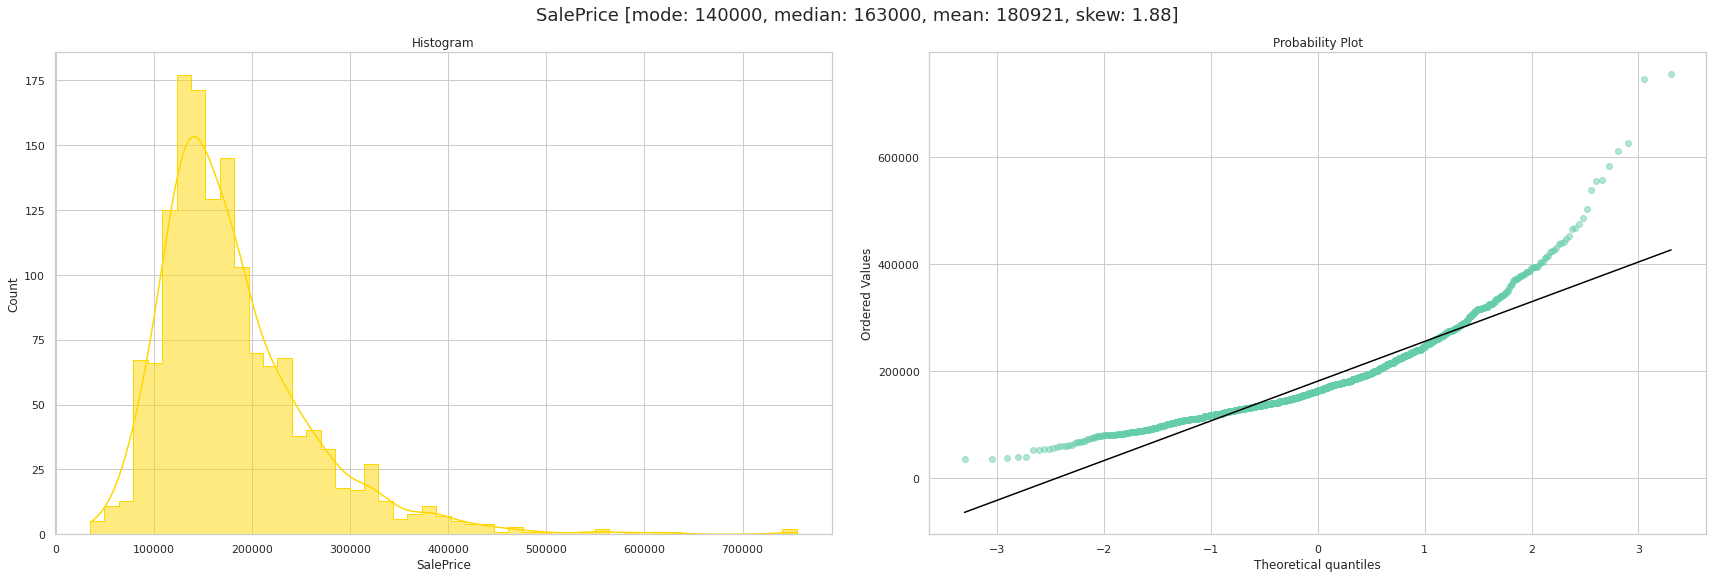

In [17]:
hist_prob_plot(target)

**Right Skewed** Distribution: Mode < Median < Mean

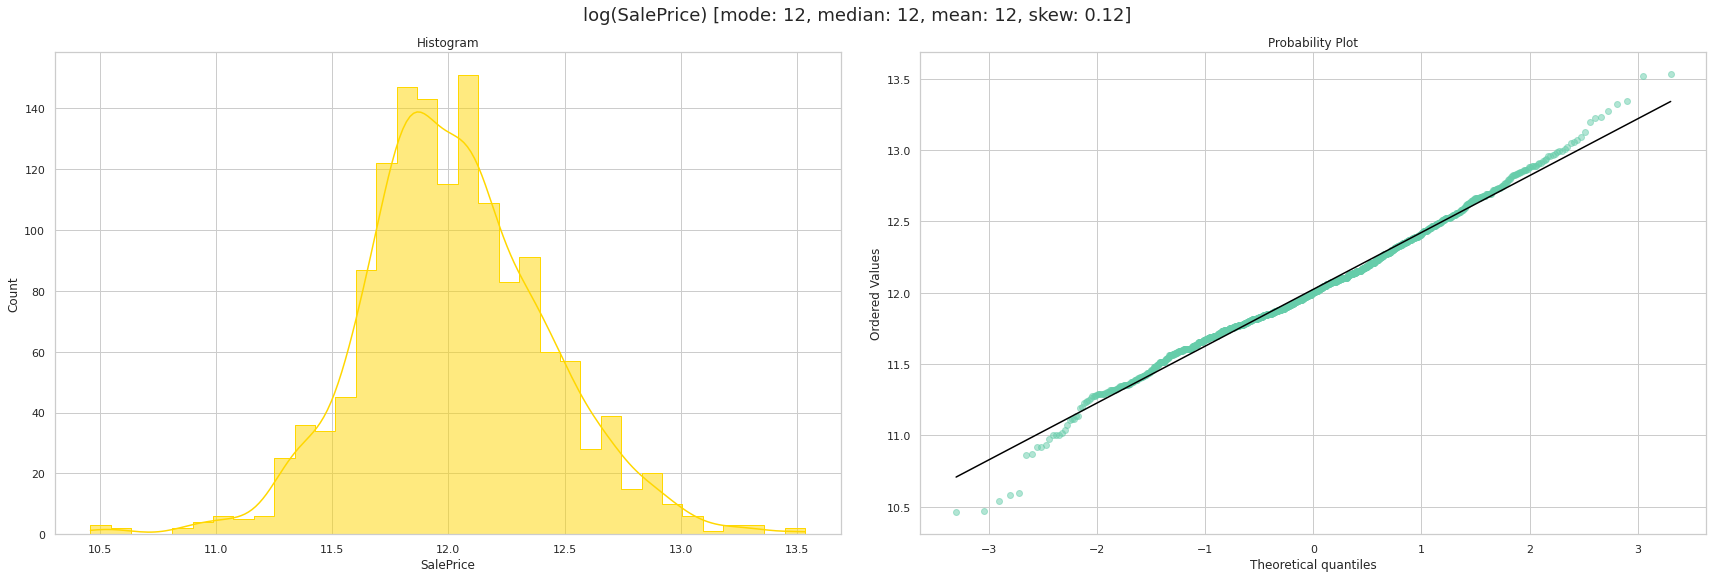

In [18]:
hist_prob_plot(np.log(target), 'log(SalePrice)')

Log of *SalePrice* is much more **normally distributed**.

In [19]:
target = np.log(original_target)

### Transformer Setup
***
I want to make some **custom transformers** to enable use of pandas dataframes with sklearn's transformers, estimators, and pipelines.  
I'm new to it and want to **practice**.

In [20]:
# Transformer to select specific features of a dataframe while preserving structure
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        output_df = X[self.features]
        return output_df

In [21]:
# Thanks to Julie Michelman's talk on how use Scikit's pipelines effectively with Pandas
# https://www.youtube.com/watch?v=BFaadIqWlAg
# https://github.com/jem1031/pandas-pipelines-custom-transformers/tree/master/code
class DataFrameFeatureUnion(TransformerMixin):

    def __init__(self, transformers):
        self.transformers = transformers

    def fit(self, X, y=None):
        for (name, t) in self.transformers:
            t.fit(X, y)
        return self

    def transform(self, X):
        Xts = [t.transform(X) for _, t in self.transformers]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        Xunion = Xunion[X.columns]
        return Xunion

# Missing Values
***
Aiming to understand **completeness** of the data.

In [22]:
def check_na(data, matrix=False):
    """
    Reports missing values for input dataframe.
    """
    if len(data) > 0:
        cols_with_missing = [col for col in data.columns if data[col].isna().any()]
        
        missing = pd.DataFrame(index=cols_with_missing, columns=['missing_count', 'percent'])
        missing.missing_count = [data[col].isna().sum() for col in cols_with_missing]
        missing.percent = round(missing.missing_count / len(data) * 100, ndigits=2)
        missing.sort_values(by='missing_count', inplace=True, ascending=False)
        if cols_with_missing:
            display(missing.T.style.background_gradient(cmap='OrRd', axis=1).format('{:.2f}'))
        print(f'\n{len(cols_with_missing)} out of {len(data.columns)} features contain missing values.\n')
        if matrix:
            missingno.matrix(data[missing.index], figsize=(30,10), fontsize=12, labels=True)

In [23]:
print('all missing values:\n')
check_na(test)

all missing values:




33 out of 79 features contain missing values.



This is the only time I look at *test*, as significant completeness disparities would need to be addressed in the preprocessing pipeline I intend to make.  
To **avoid leakage**, I'll ignore *test* until the model is trained.

train missing values:




19 out of 79 features contain missing values.



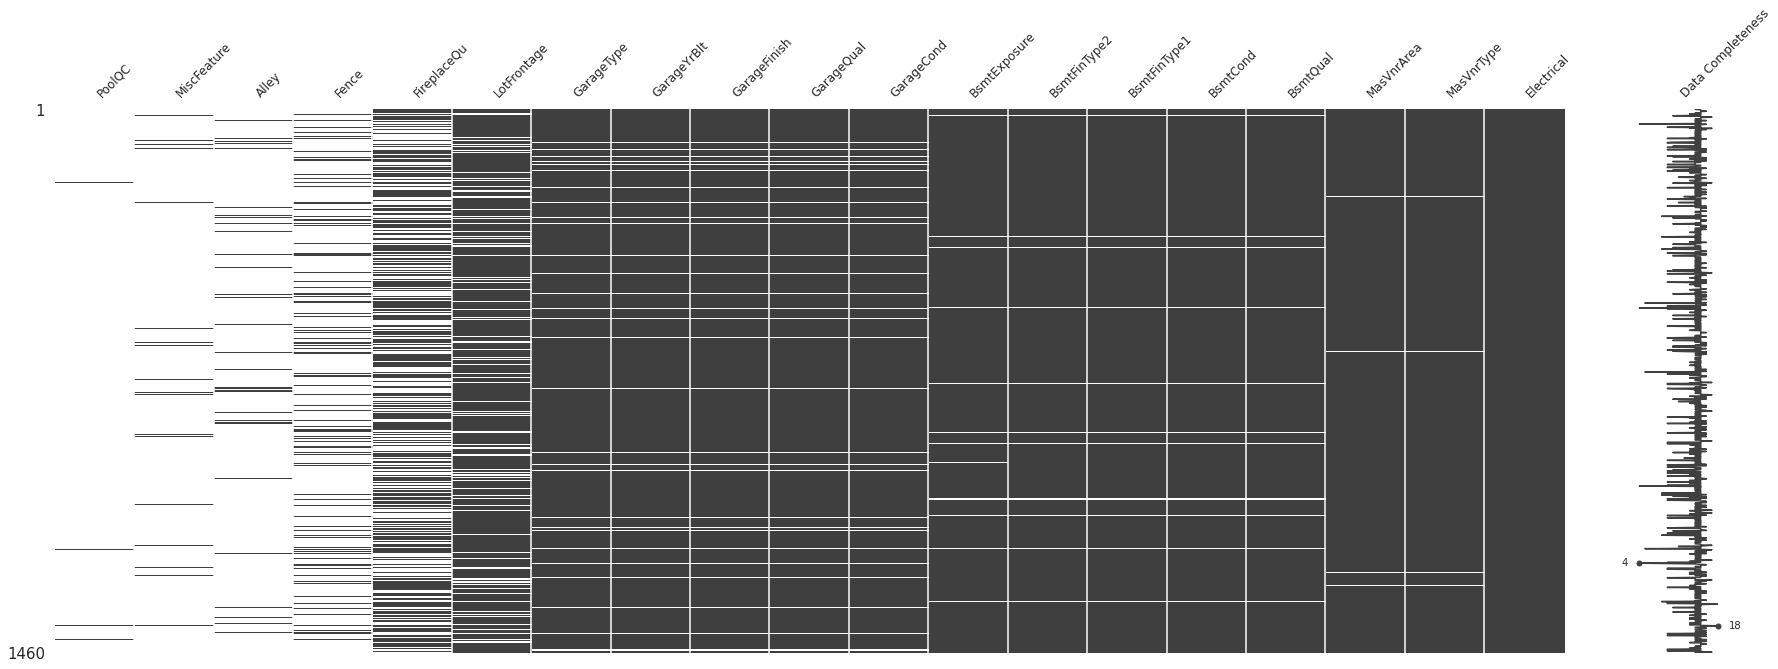

In [24]:
print('train missing values:\n')
check_na(train, matrix=True)

*train* and *test* have similar instances of missing values so I can set up a pipeline to impute both.

# Preprocessing
***
My first round of preprocessing involves **handling missing values** and rudimentary **encoding** of categoricals.

In [25]:
numericals = train.select_dtypes(exclude='object').columns.tolist()
categoricals = train.select_dtypes(include='object').columns.tolist()

I referred to *data_description.txt* to discover which categorical features had integer values.

In [26]:
# Some features with numerical datatypes belong to categorical featureset
num_to_cat = ['MSSubClass', 'OverallQual', 'OverallCond']
numericals = list(set(numericals) - set(num_to_cat))
categoricals.extend(num_to_cat)
(len(numericals) + len(categoricals)) == len(list(original_train.columns))

True

## Numerical and Categorical Imputation
<br>The *data_description.txt* clearly denotes which values of NA actually indicate a "not present" label: *None*
<br>I'll transform those features explicitly.

In [27]:
# Nones according to data_description.txt
nones = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
         'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
# Remaining categorical features
not_nones = list(set(categoricals) - set(nones))

How I'll **handle missing values**:
- attempt to identify and handle actual missing entries, if needed
- identify which features use NA's to denote an absence (by refering to data_description.txt)
    - impute zero for numericals
    - impute 'None' for categoricals


At this stage, I could have simply used Panda's .fillna() to perform the desired transforms.  
However, I took this opportunity to practice building a custom transformer and pipeline to merge the functionality of Sklearn and Pandas.  

In [28]:
class DataFrameImputer(TransformerMixin):
    """
    Provide SimpleImputer strategy and fill_value.
    """
    
    def __init__(self, strategy=None, fill_value=None):
        self.imputer = None
        self.strategy = strategy
        self.fill_value = fill_value
        
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy=self.strategy, fill_value=self.fill_value).fit(X)
        return self
    
    def transform(self, X):
        imputed = self.imputer.transform(X)
        df_imputed = pd.DataFrame(imputed, index=X.index, columns=X.columns)
        df_imputed = df_imputed.astype(X.dtypes.to_dict())
        return df_imputed

In [29]:
imputer_pipeline = Pipeline([
    ('features', DataFrameFeatureUnion([
        ('numericals', Pipeline([
            ('select', FeatureSelector(numericals)),
            ('num_imputer', DataFrameImputer(strategy='constant', fill_value=0))
        ])),
        ('cats_nones', Pipeline([
            ('select', FeatureSelector(nones)), 
            ('none_imputer', DataFrameImputer(strategy='constant', fill_value='None'))
        ])),
        ('cats_freqs', Pipeline([
            ('select', FeatureSelector(not_nones)),
            ('freq_imputer', DataFrameImputer(strategy='most_frequent'))   
        ]))
    ]))
])

## Categorical Feature Identification and Encoding
Next, I opt to **encode** the categoricals using Panda's CategoricalDtype.  
CategoricalDtype retains values and allows to assign custom ranks.  
Where the feature is **ordinal**, I want to **provide the ranks** myself.  
By refering to *data_description.txt*, I made some subjective decisions on whether they were ordinal or nominal.

In [30]:
ordinals = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 
            'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

nominals = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 
            'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
            'Heating', 'CentralAir', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']

In [31]:
# Ordinals' custom ranks
ten_ranks = [str(n) for n in range(1,11)]
five_ranks = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
fin_ranks = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

ordinal_ranks = {'LotShape' : ['IR3', 'IR2', 'IR1', 'Reg'],
                 'Utilities' : ['ELO', 'NoSeWa', 'NoSeWr', 'AllPub'],
                 'LandSlope' : ['Gtl', 'Mod', 'Sev'],
                 'OverallQual' : ten_ranks,
                 'OverallCond' : ten_ranks,
                 'ExterQual' : five_ranks,
                 'ExterCond' : five_ranks,
                 'BsmtQual' : five_ranks,
                 'BsmtCond' : five_ranks,
                 'BsmtExposure' : ['None', 'No', 'Mn', 'Av', 'Gd'],
                 'BsmtFinType1' : fin_ranks,
                 'BsmtFinType2' : fin_ranks,
                 'HeatingQC' : five_ranks,
                 'KitchenQual' : five_ranks,
                 'Functional' : ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                 'FireplaceQu' : five_ranks,
                 'GarageFinish' : ['None', 'Unf', 'RFn', 'Fin'],
                 'GarageQual' : five_ranks,
                 'GarageCond' : five_ranks,
                 'PavedDrive' : ['N', 'P', 'Y'],
                 'PoolQC' : five_ranks,
                 'Fence' : ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']}

In [32]:
class DataFrameCategoricalEncoder(TransformerMixin):
    
    def __init__(self, cat_features=[], ranks={}):
        self.cat_features = cat_features
        self.ranks = ranks
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed = X.copy()
        # All cats as str and category
        transformed[self.cat_features] = transformed[self.cat_features].astype(str).astype('category')
        # All ordinals ordered
        for feature, categories in self.ranks.items():
            transformed[feature] = transformed[feature].astype(CategoricalDtype(categories, ordered=True))
        return transformed

In [33]:
# check cardinality of nominative categoricals
pd.concat((train, test))[nominals].nunique().sort_values(ascending=False)

Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
RoofStyle         6
Foundation        6
Heating           6
GarageType        6
SaleCondition     6
BldgType          5
LotConfig         5
MSZoning          5
Electrical        5
LandContour       4
MasVnrType        4
MiscFeature       4
Alley             2
CentralAir        2
Street            2
dtype: int64

I check cardinality to consider one-hot encoding.  
Several features have relatively **high cardinality**.  
XGBoost doesn't necessarily perform better with OH encoding anyways.  
I'll just label encode all for now.

In [34]:
encoder_pipeline = Pipeline([
    ('cats_ords_encoder', DataFrameCategoricalEncoder(categoricals, ordinal_ranks))
])

In [35]:
baseline_pipeline = Pipeline([
    ('imputer', imputer_pipeline),
    ('encoder', encoder_pipeline)
])

In [36]:
train = baseline_pipeline.fit_transform(train)

# Baseline Score
***
From Kaggle Learn's course on feature engineering, I learned how desirable it is to acquire a **baseline metric** as early as possible.  
This will be my "North Star" for any changes I make. It isn't true north, but will keep me heading in the right direction.

In [37]:
# Modified from Kaggle Learn's Feature Engineering course
def score_dataset(X, y, model=XGBRegressor()):

    X=X.copy()
    # Extract ranks of categoricals
    for categorical in X.select_dtypes(["category"]):
        X[categorical] = X[categorical].cat.codes
    # Metric: RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [38]:
baseline_score = score_dataset(train, target)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.13876 RMSLE


In [39]:
scores = {'baseline' : baseline_score}

### (Functions for EDA)
***

In [40]:
# Modified from Kaggle Learn's Feature Engineering course
def make_mi_scores(X, y):
    X = X.copy()
    for categorical in X.select_dtypes(["category"]):
        X[categorical] = X[categorical].cat.codes

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)
    mi_scores = pd.Series(mi_scores, name="MIS", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [41]:
def plot_mi_scores(mi_scores, threshold=0):
    mi_scores = mi_scores[mi_scores>threshold].sort_values(ascending=False)  
    sns.barplot(x=mi_scores.values, y=mi_scores.index, color='gold', alpha=0.5)
    sns.despine(left=True, bottom=True)
    plt.title(f"Mutual Information Scores (Above {threshold})")   

In [42]:
def num_feature_plots(data, target, feature):
    """
    For given feature, display univariate and bivariate plots.
    'data' is dataframe including all features.
    'target' is series of prediction target.
    'feature' is string of specified column in 'data'.
    Plots include:
        - Histogram with KDE
        - Probability Plot
        - Scatter plot with 'feature' and 'target'. 3rd order regression included (not robust).
        - Top correlations using Pearson metrics. Direction of correlation denoted. Displays all correlations above magnitude of 0.5, or at least 5 top.
    """
    mis = make_mi_scores(pd.DataFrame(data[feature]), target)[0]
    
    fig = plt.figure(figsize=(24,5), constrained_layout=True)
    fig.suptitle(f'{feature} (MIS: {mis:.3f})', fontsize=18)
    fig.set_constrained_layout_pads(w_pad=0.2, w_space=0.2, h_pad=0.08, h_space=0.2)
    
    # Histogram with KDE
    ax1 = fig.add_subplot(1,4,1)
    ax1.set(title='Histogram')
    sns.histplot(data[feature], stat='count', kde=True, 
                 element='step', color='gold', 
                 ax=ax1)
    
    # Probability Plot
    ax2 = fig.add_subplot(1,4,2)
    ax2.set(title='Probability Plot')
    stats.probplot(data[feature], plot=sns.lineplot(ax=ax2))
    ax2.get_lines()[0].set(color='mediumaquamarine', alpha=0.5)
    ax2.get_lines()[1].set_color('black')
    
    # Scatter with Regression
    ax3 = fig.add_subplot(1,4,3)
    ax3.set(title='Scatter and Regression (x\u00b3) with Target')
    sns.regplot(x=feature, y=target, data=data,
                x_jitter=0.1,
                color='gold', scatter_kws={'alpha':1/3},
                order=3, line_kws={'color':'black'}, ci=None,
                ax=ax3)
    
    # Top Correlations
    ax4 = fig.add_subplot(1,4,4)
    ax4.set(title='Top Correlations (Pearson)', xlim=(0,1))
    # Sort correlations by magnitude and note direction (ignore self correlation) 
    corr = pd.concat([data, target], axis=1).corr()[feature].drop(feature)
    corr = corr.reindex(corr.abs().sort_values(ascending=False).index)
    corr = pd.DataFrame({'Correlation': corr.abs(), 'Positive': corr >= 0})
    highly_corr = corr[corr.Correlation >= 0.5]
    # Plot at least the top 5 correlated features
    top_corr = corr[:5] if (len(highly_corr) < 5) else highly_corr
    sns.barplot(data=top_corr, x='Correlation', y=top_corr.index, 
                hue='Positive', dodge=False, palette={True:'gold', False:'mediumaquamarine'}, alpha=0.5,
                ax=ax4)
    ax4.legend(title='Positive Corr', loc='lower right')

In [43]:
# test num_feature_plots()
#num_feature_plots(baseline_train[numericals], target, '1stFlrSF')

In [44]:
def cat_feature_plots(data, target, feature):
    """
    For given categorical feature, display univariate and bivariate plots.
    'data' is dataframe including all features.
    'target' is series of prediction target.
    'feature' is string of specified column in 'data'.
    Plots include:
        - Count plot
        - Distribution plot: constant-width violin plot overlayed with point plot (y-range: 1st to 99th quantile)
    """
    palette = sns.blend_palette(['gold', 'thistle', 'mediumaquamarine'], n_colors=data[feature].nunique())
    count_order = data[feature].value_counts().index
    median_order = pd.concat([data[feature], target], axis=1).groupby(feature).median().sort_values(by=target.name, ascending=True).index.tolist()
    
    mis = make_mi_scores(pd.DataFrame(data[feature]), target)[0]
    
    cat_fig = plt.figure(figsize=(24,5), constrained_layout=True)
    cat_fig.suptitle(f'{feature} (MIS: {mis:.3f})', fontsize=18)
    cat_fig.set_constrained_layout_pads(w_pad=0.2, w_space=0.2, h_pad=0.08, h_space=0.2)
    
    # Univariate/Counts
    ax1 = cat_fig.add_subplot(1,2,1)
    ax1.set(title='Category counts (ordered by count)')
    sns.countplot(data=data, x=feature, 
                  order=count_order, palette=palette, alpha=0.5, linewidth=2, edgecolor='gray',
                  ax=ax1)
    
    # Bivariate/Distributions
    ax2 = cat_fig.add_subplot(1,2,2)
    ax2.set(title='Category distributions (ordered by median)')
    # constant violin width
    sns.violinplot(data=data, x=feature, y=target,
                   order=median_order, palette=palette,
                   inner=None, scale='width', cut=0,
                   ax=ax2)
    sns.pointplot(data=data, x=feature, y=target,
                  order=median_order,
                  ax=ax2)
    ax2.set(ylim=(target.quantile(0.01),target.quantile(0.99)))
    
    # (Set violin plot opacity)
    for violin in ax2.collections[::1]:
        violin.set_alpha(0.5)
    
    # (Account for high cardinality)
    if data[feature].nunique() > 10:
        ax1.tick_params(axis='x', labelrotation=45)
        ax2.tick_params(axis='x', labelrotation=45)
    
    # (Hide x labels)
    ax1.set_xlabel('')
    ax2.set_xlabel('')

In [45]:
# test cat_feature_plots
#cat_feature_plots(baseline_train[categoricals], target, 'Neighborhood')

In [46]:
def plot_set(data, target, features):
    for feature in data[features].select_dtypes(exclude='category').columns:
        num_feature_plots(data, target, feature)
    for feature in data[features].select_dtypes(include='category').columns:
        cat_feature_plots(data, target, feature)  

In [47]:
def compare_score(dataset, selected=''):
    if selected == '':
        lowest = min(scores.values())
        print(f"{'Lowest RMSE':<16}{lowest:.5f}")
    else:
        lowest = scores[selected]
        print(f"{'Selected RMSE':<16}{lowest:.5f}")
        
    score = score_dataset(dataset, target)
    print(f"{'New RMSE':<16}{score:.5f}")
    if score < lowest:
        print(f"{'Better by':<16}{lowest-score:.5f}")
    else:
        print(f"{'Worse by':<16}{score-lowest:.5f}")

# Feature Selection
***
Generally, I would perform feature selection after EDA and feature engineering, before training.  
However, I think trimming some features now would speed up EDA, if I can drop those unlikely to be useful in feature engineering.  
<br>
My objective is to reduce the feature set to include **informative and non-redundant** features.  
A useful metric for this is the **Mutual Information Score (MIS)** of a feature and the target.  
For numerical features, I'll look at MIS and correlations (SULOV).  
For categorical features, I'll look at MIS and class balances.  

## Mutual Information

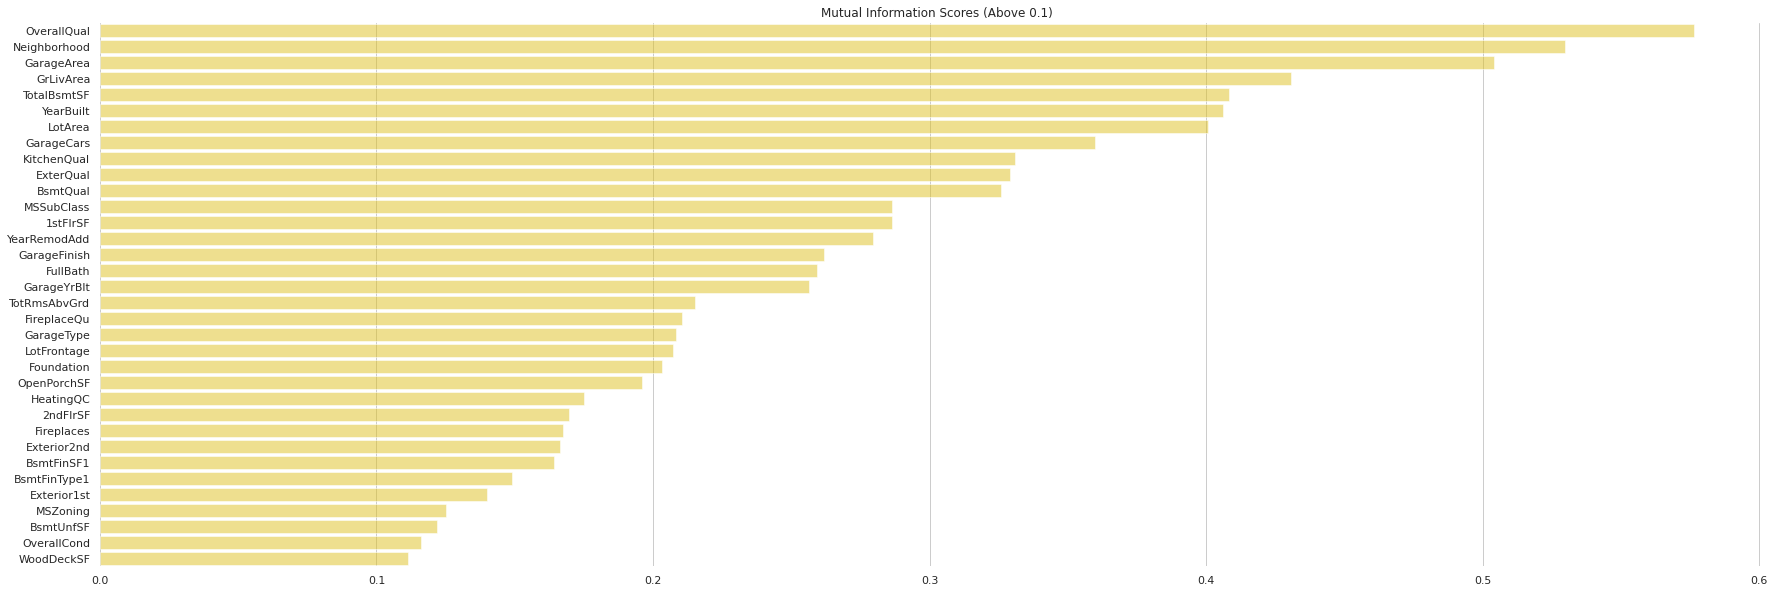

In [48]:
baseline_mi_scores = make_mi_scores(train, target)
plot_mi_scores(baseline_mi_scores, 0.1)

High MIS features are likely useful, but even low MIS features may have usefulness that can be exposed with feature engineering.  
Unsurprisingly, some features describing size, quality, and location of the building score quite well.

## Correlation and SULOV
FeatureWiz is a python package for feature selection.  
I wanted to see if I could implement part of it myself, using its pseudocode.

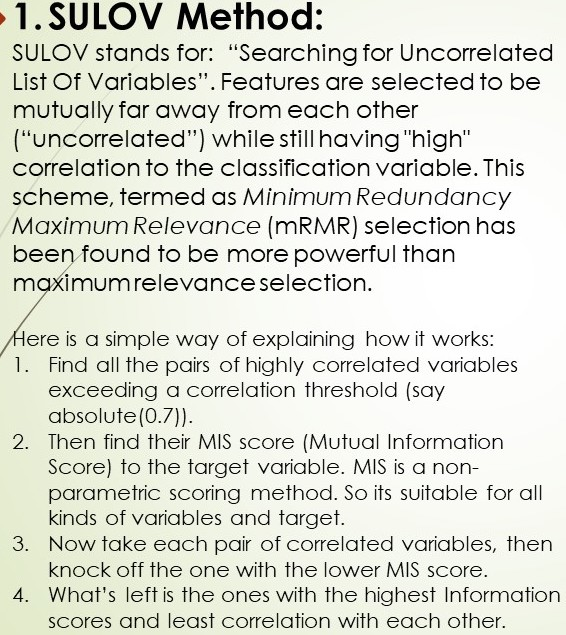

In [49]:
class Sulov:
    def __init__(self):
        self.correlations = train.corr()
        self.correlations[self.correlations == 1] = 0
    
    def fit(self, cutoff):
        keeps = set()
        for feature in self.correlations.index:
            # for each feature, get list of features with correlation above cutoff
            for index in self.correlations[(self.correlations.abs() >= cutoff)[feature]].index.tolist():
                # compare index-target with feature-target mi scores
                if baseline_mi_scores[index] > baseline_mi_scores[feature]: 
                    keeps.add(index)
                else:
                    keeps.add(feature)
        drops = set(self.correlations.index) - keeps
        return keeps, drops

Then I'll try to optimize the *cutoff* with the baseline model score as the loss function.

In [50]:
def sulov_objective(trial):
    cutoff = trial.suggest_uniform('cutoff', 0.1, 1)
    
    sulov = Sulov()
    keeps, drops = sulov.fit(cutoff)
    
    y = target.copy()
    X = train.drop(drops, axis=1).copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    reg = XGBRegressor()
    fitted = reg.fit(X, y)
    
    score = cross_val_score(fitted, X, y, cv=5, scoring="neg_mean_squared_error")
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [51]:
#sulov_study = optuna.create_study(direction='minimize')
#sulov_study.optimize(sulov_objective, n_trials=100, timeout=600)

In [52]:
#best_cutoff = sulov_study.best_trial.params.get('cutoff')
best_cutoff = 0.215 # best trial {'cutoff': 0.2127053918449865} with RMSE 0.13306083219194825

sulov = Sulov()
sulov_keeps, sulov_drops = sulov.fit(best_cutoff)
scores['sulov'] = score_dataset(train.drop(sulov_drops, axis=1), target)
scores

{'baseline': 0.13875698578094056, 'sulov': 0.13306083219194825}

In [53]:
sulov_drops

{'3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'EnclosedPorch',
 'GarageYrBlt',
 'KitchenAbvGr',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'WoodDeckSF',
 'YrSold'}

In [54]:
# Future Mark here. Keeping BsmtFinSF2 in the set for EDA, removing after.
sulov_drops.remove('BsmtFinSF2')

## Class Imbalance
***
<br>A large portion of the feature set is imbalanced. As a result, those features are less informative and more difficult to analyze.
<br>
<br>[In the following plots, the category distribution plot gives an idea of the distribution of values of each category across the target.
<br>The pointplot connecting the violins indicates each category's central tendency while indicating its uncertainty with error bars.
<br>The link between uncertainty and imbalanced categories is noticable when comparing both plots.]
<br>
<br>Consider *Condition1*.

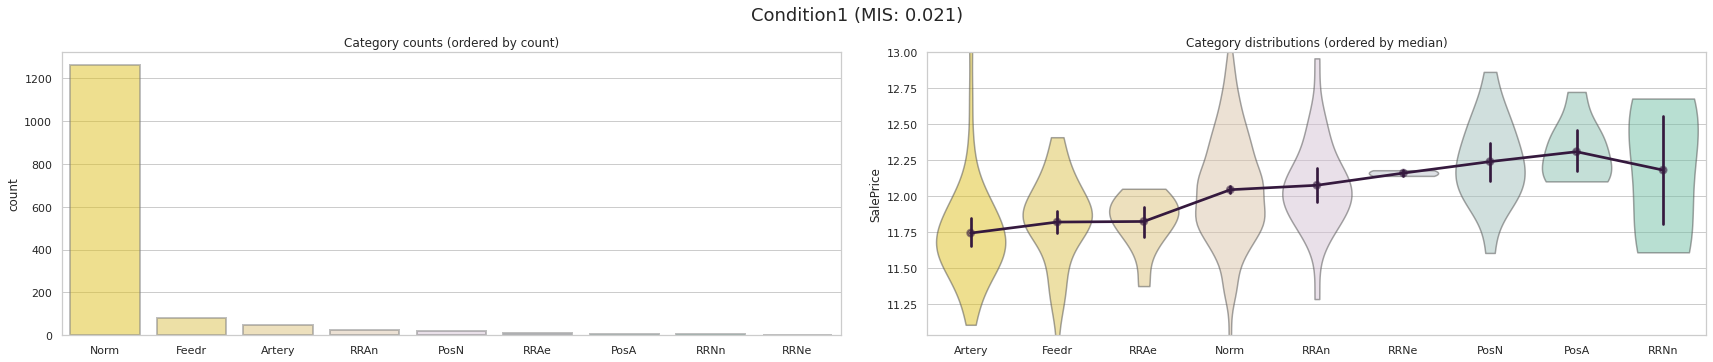

In [55]:
cat_feature_plots(train,  target, 'Condition1')

In [56]:
train.Condition1.value_counts(normalize=True)

Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64

Although categories appear to have a desirable spread across values of *SalePrice*, the *Norm* category is overwhelming (86%) and MIS is low (0.02).
<br>Dropping such a feature improves baseline model performance.

In [57]:
compare_score(train.drop('Condition1', axis=1), 'baseline')

Selected RMSE   0.13876
New RMSE        0.13595
Better by       0.00281


I'll look at the percentage of the dominant value in each feature to help determine which categorical features to consider for selection.
<br>I'm looking for features with low MIS and imbalanced classes that further improve the score after the SULOV selection.

In [58]:
balances = {f: train[f].value_counts(normalize=True).tolist()[0] for f in train[categoricals].columns}
balances = pd.Series(data=balances.values(), index=balances.keys(), name='bal').sort_values(ascending=False)
balances = pd.concat((balances, baseline_mi_scores), axis=1)
balances[balances.bal > 0.95]

bal           MIS
Utilities    0.999315  1.887379e-15
Street       0.995890  0.000000e+00
PoolQC       0.995205  0.000000e+00
Condition2   0.989726  2.754397e-03
RoofMatl     0.982192  7.269945e-03
Heating      0.978082  1.682680e-02
MiscFeature  0.963014  1.250063e-03

With a little brute force searching, it seems excluding features that have a class with over 98% dominance leads to further improvement after SULOV. 

In [59]:
balance_drops = set(balances[balances.bal>0.98].index)
balance_drops

{'Condition2', 'PoolQC', 'RoofMatl', 'Street', 'Utilities'}

In [60]:
selected_drops = sulov_drops.union(balance_drops)
train = train.drop(selected_drops, axis=1)
compare_score(train)
scores['selected_drops'] = score_dataset(train, target)

Lowest RMSE     0.13306
New RMSE        0.13081
Better by       0.00225


Feature selection reduces the feature set's size significantly.

In [61]:
len(selected_drops)

22

Surprisingly, the previous example of dropping *Condition1* does not improve the score after feature selection via SULOV and imbalance.  
Looking at class imbalance and MIS alone is not sufficient to guide feature selection.  
This demonstrates the intricacies of feature selection, requiring case by case study.  
XGBoost does a better job than most algorithms at learning to ignore uninformative features.  
I'll let the boosted trees do the rest.

In [62]:
compare_score(train.drop('Condition1', axis=1))

Lowest RMSE     0.13081
New RMSE        0.13480
Worse by        0.00398


# Exploratory Data Analysis & Feature Engineering
***
At this stage I haven't discovered much about the dataset.  
I want to discover how features interact with each other and the target.  
I'll perform some **univariate and multivariate analysis**.  
<br><br>
I'll also try to **create some new features** by combining those that stand out to me during analysis.  
I generally try to leverage an informative feature by combining it with low MIS features to try to expose some interactions.

## Grouping Features
As there are so many features, it's difficult to consider more than a handful at a time.  
I'll **subjectively group** features and look at one group at a time. 

In [63]:
group_location = {'MSZoning', 'Neighborhood', 'LotConfig', 'Condition1', 'Condition2'}
group_property = {'MSSubClass', 'Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope'}
group_external = {'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence'}
group_exterior = {'BldgType', 'HouseStyle',  'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation'}
group_interior = {'Utilities', 'Heating', 'CentralAir', 'Electrical', 'Fireplaces'}
group_size = {'LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'}
group_qc = {'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu'}
group_bsmt = {'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'}
group_garage = {'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive'}
group_bath = {'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'}
group_other = {'YearBuilt', 'YearRemodAdd', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'}
all_groups = [group_location, group_property, group_external, group_exterior, group_interior, group_size, group_qc, group_bsmt, group_garage, group_bath, group_other]
for group in all_groups:
    group.difference_update(selected_drops)

I'll plot figures for each feature, looking out for: 
- distribution quality (diversity in values, skew, spread across target) 
- trends
- outliers
- correlations (redundancy)
- predictive usefulness

### Group: Location
First, I'll look at some features related to location of the property.

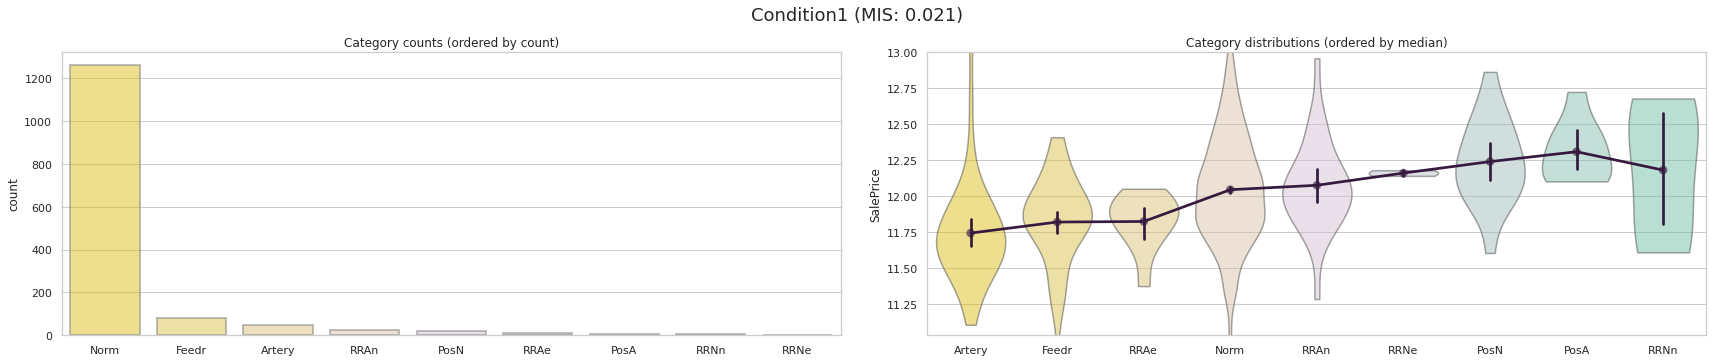

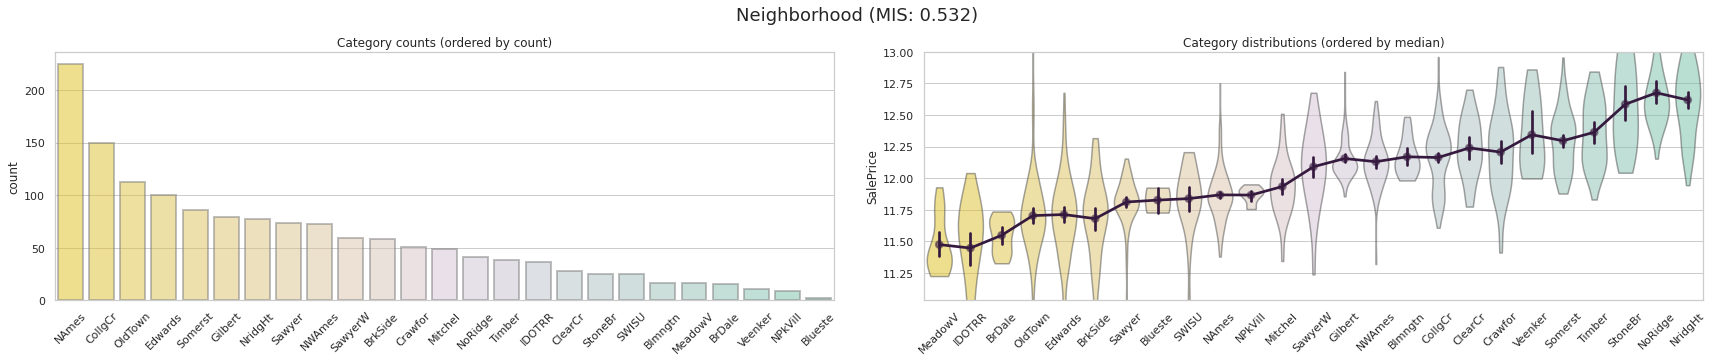

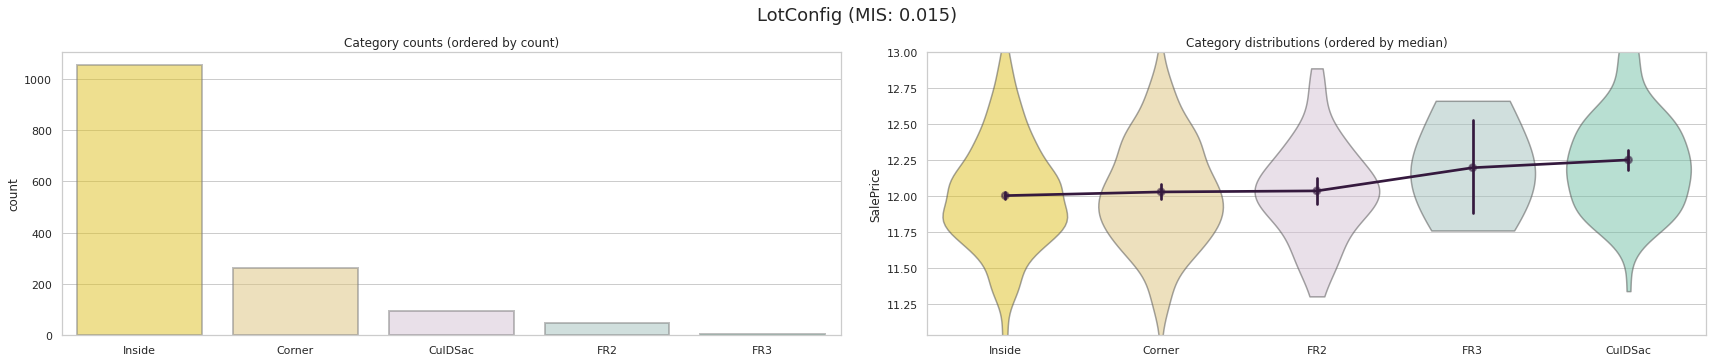

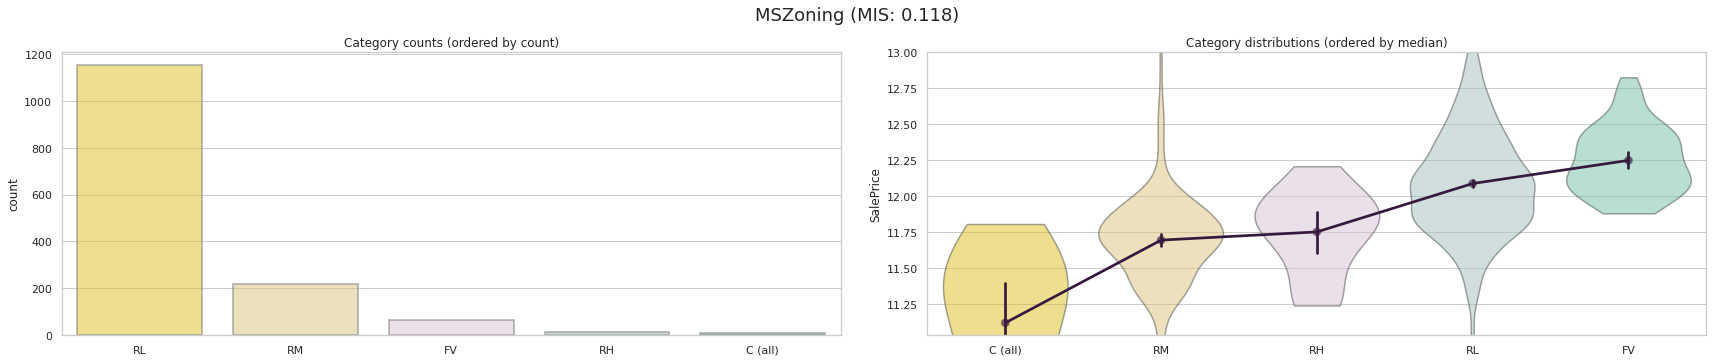

In [64]:
plot_set(train, target, group_location)

*LotConfig's* categories hardly vary across *SalePrice* [ignore].  
<br>
*MSZoning* and *Condition1* seems to spread nicely across *SalePrice*, but may be too imbalanced to draw reliable conclusions.  
<br>
*Neighborhood* has great diversity and distribution spread, supporting its high MIS. [explore]

In [65]:
(pd.concat((target, train), axis=1)
.groupby('Neighborhood')
.mean()
.sort_values(by='SalePrice', ascending=True)
).style.background_gradient(cmap='coolwarm')

Here, I've aggregated averages across *Neighborhood's* classes and sorted by the target.  
The averages of the features describing size seem to correlate with the averages of *SalePrice* across classes of *Neighborhood*.    
<br>I'll take a closer look at those next.

In [66]:
train = train.assign(SF = lambda x: (train.TotalBsmtSF + train.GrLivArea + train.GarageArea))
compare_score(train)
scores['add_SF'] = score_dataset(train, target)

Lowest RMSE     0.13081
New RMSE        0.13923
Worse by        0.00842


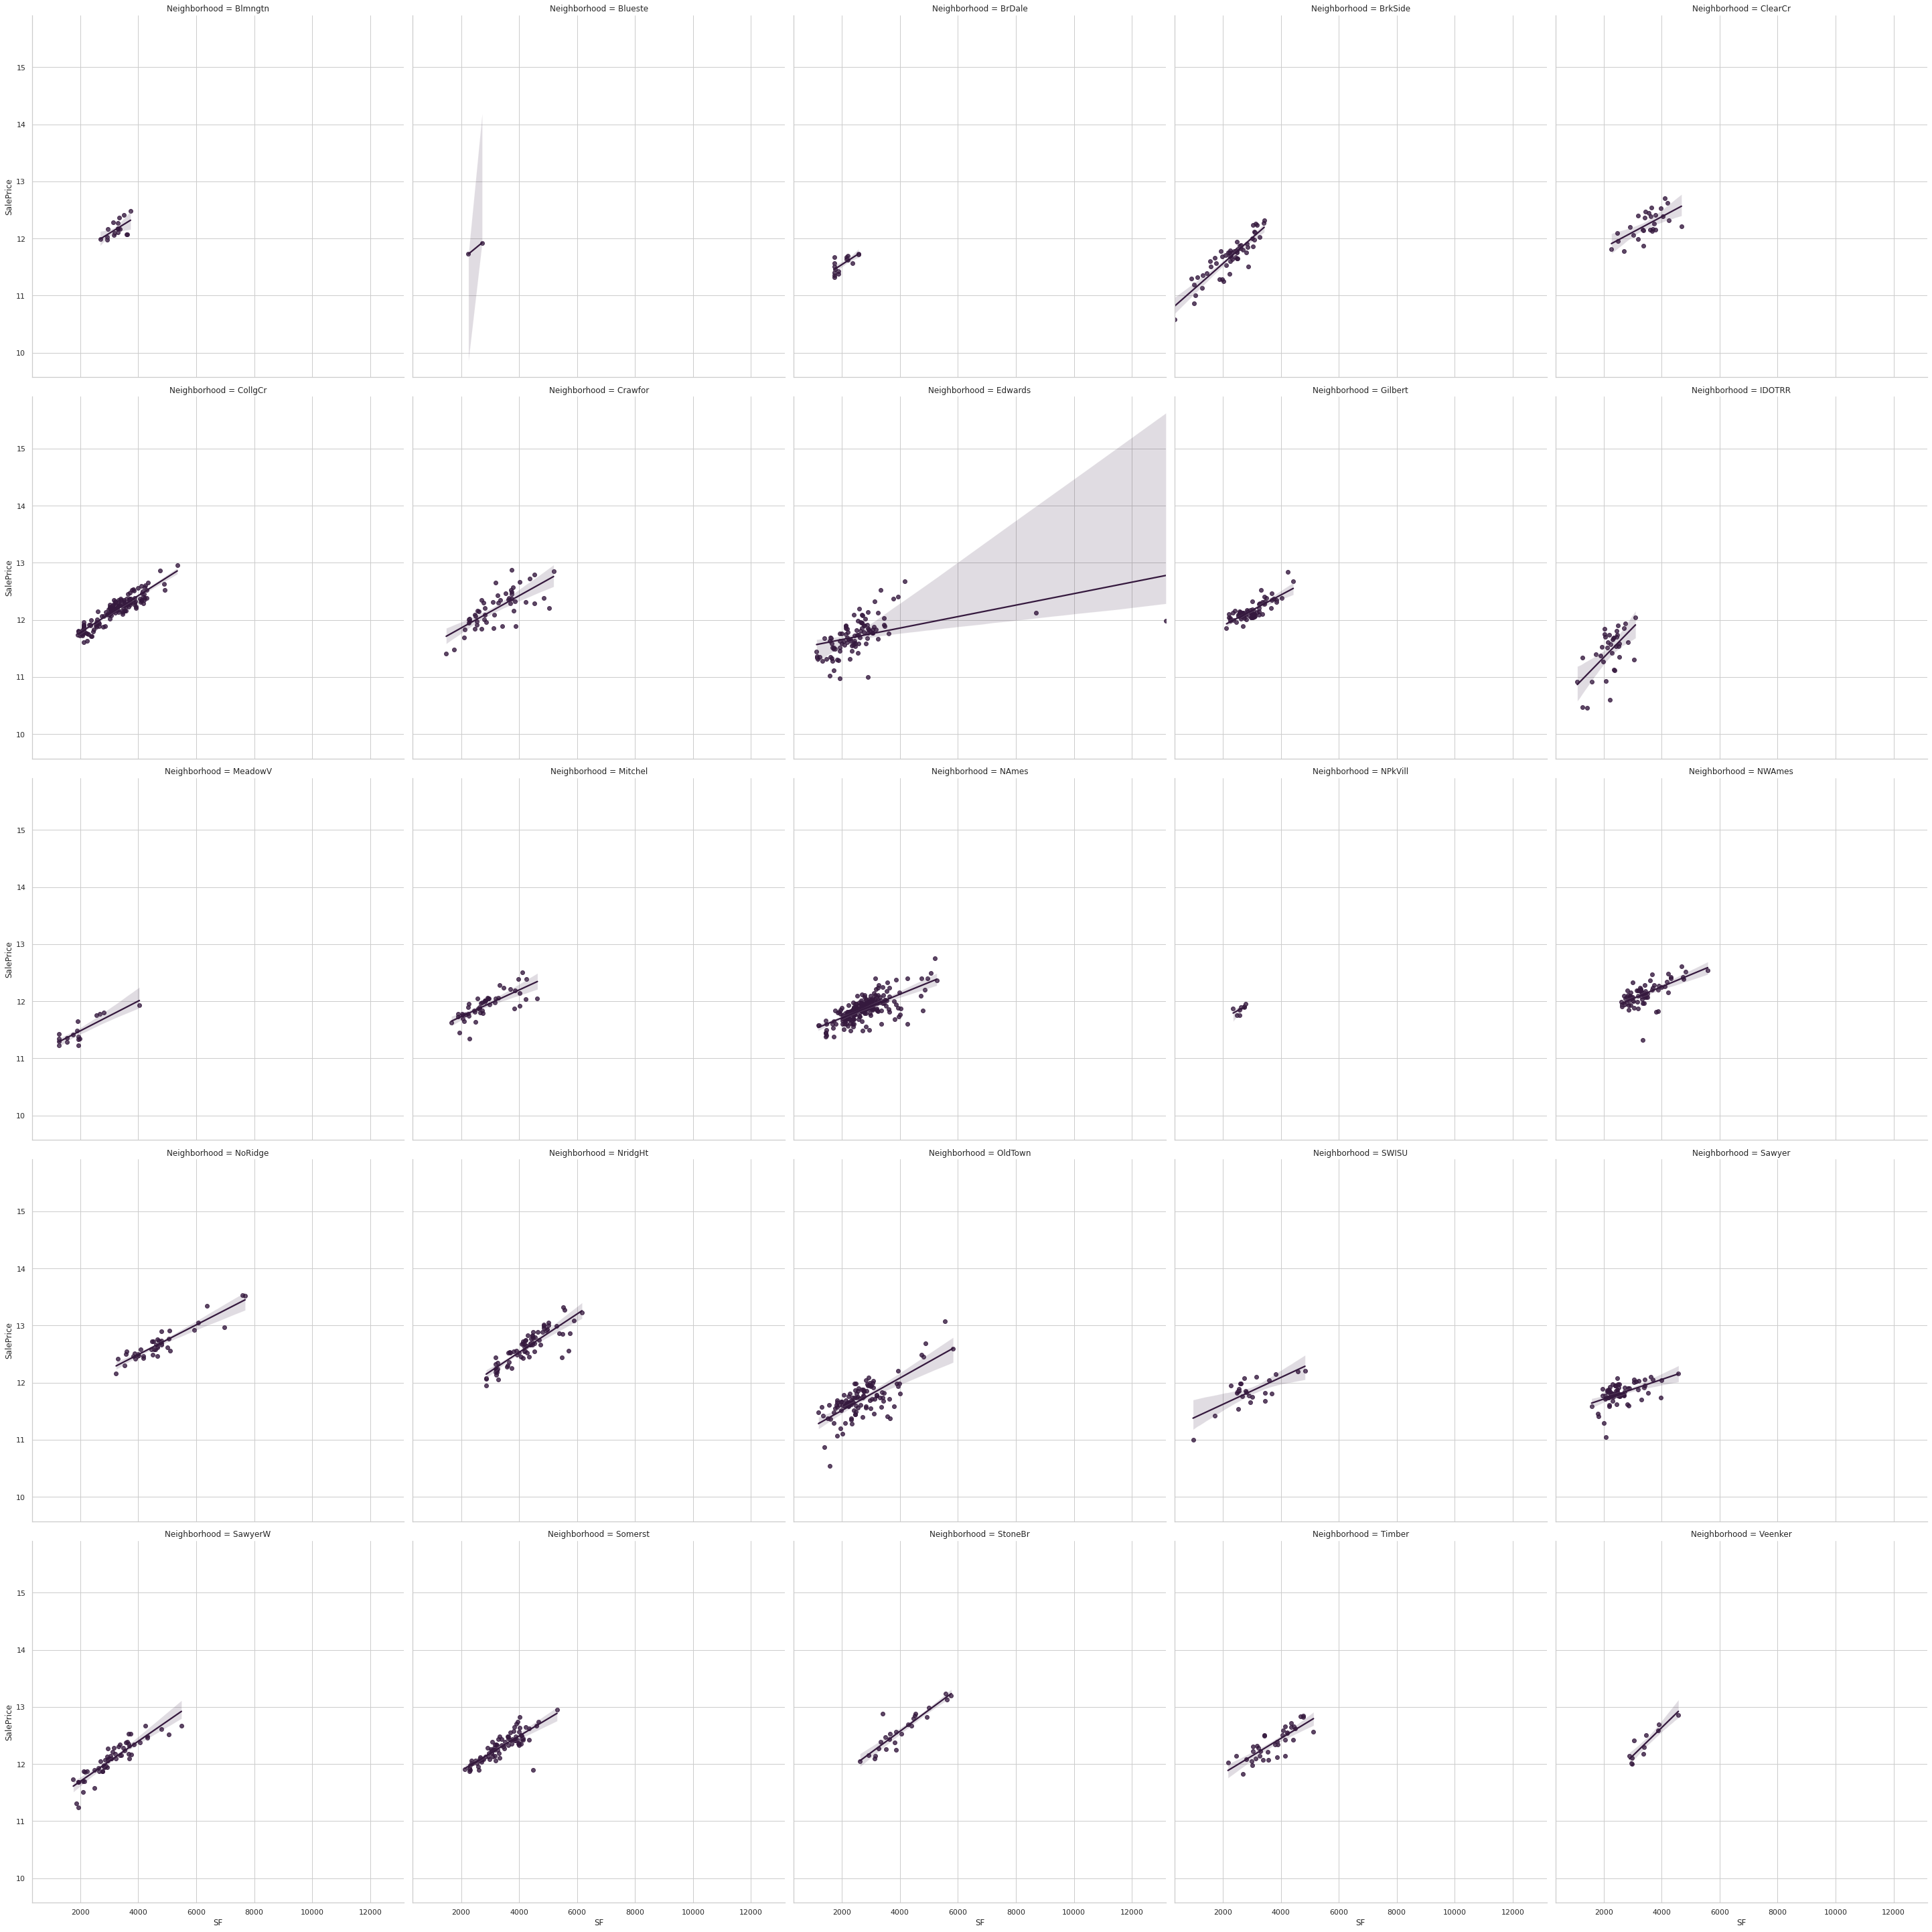

In [67]:
sns.lmplot(x='SF', y='SalePrice', col="Neighborhood", col_wrap=5, height=8, sharey=True,
           data=pd.concat((train, target), axis=1))

I can clearly spot some outliers which I'll omit in training.

In [68]:
# I found these indices manually
outlier_ids = [524, 1299, 633, 1325, 689]

In [69]:
score_dataset(train.drop(outlier_ids, axis=0), target.drop(outlier_ids, axis=0))

0.12763966828018036

In [70]:
score_dataset(train.drop('SF', axis=1).drop(outlier_ids, axis=0), target.drop(outlier_ids, axis=0))

0.12849140829001854

In [71]:
train = train.drop(outlier_ids, axis=0)
target = target.drop(outlier_ids, axis=0)
scores['drop_outliers_1'] = score_dataset(train, target)

In [72]:
scores

{'baseline': 0.13875698578094056,
 'sulov': 0.13306083219194825,
 'selected_drops': 0.13081064629141778,
 'add_SF': 0.13923006717367292,
 'drop_outliers_1': 0.12763966828018036}

The **outliers had a large impact** on the new *SF* feature.

#### Group: Size

In [73]:
group_size.add('SF')

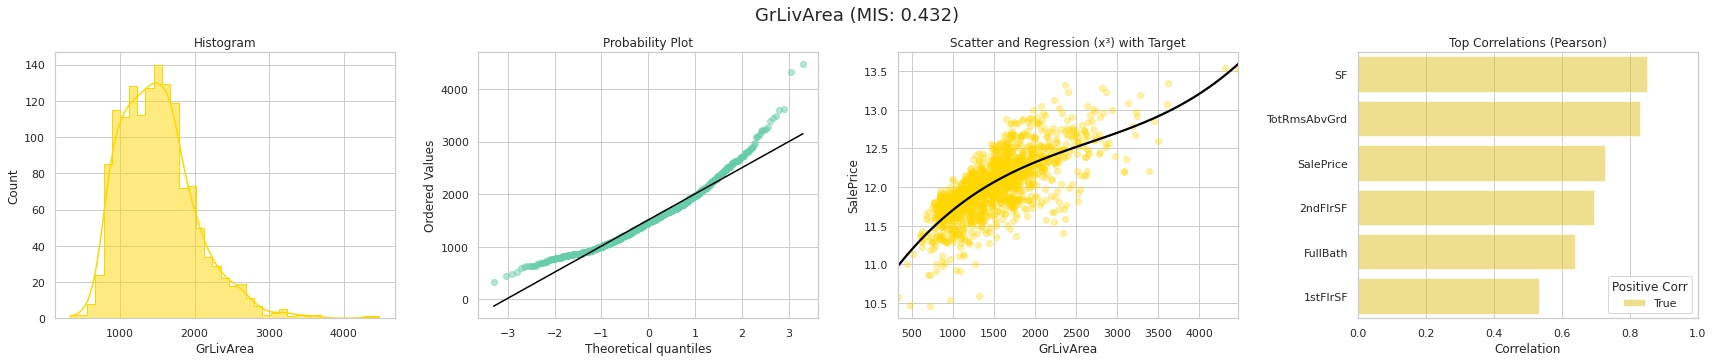

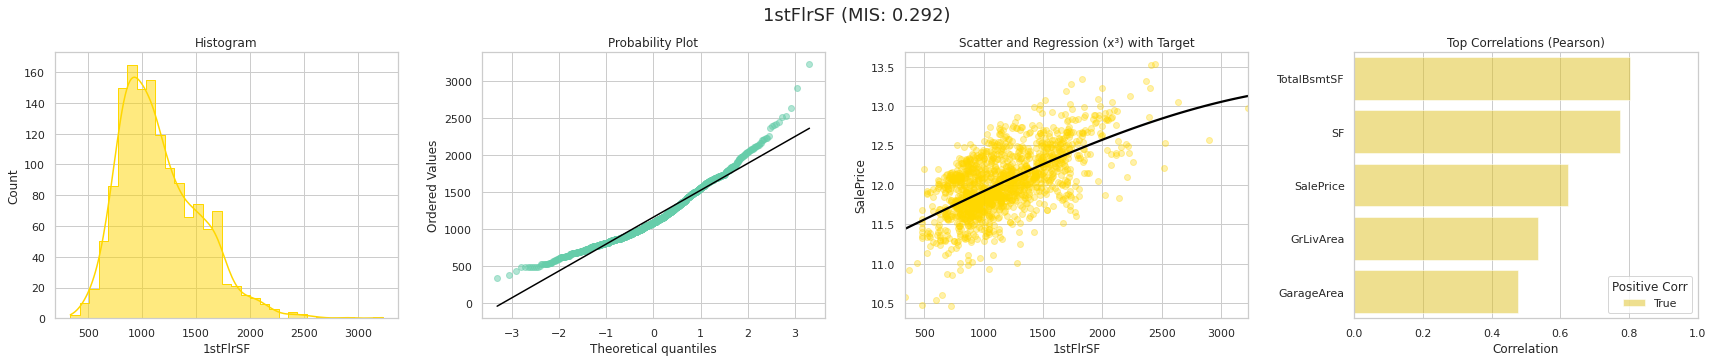

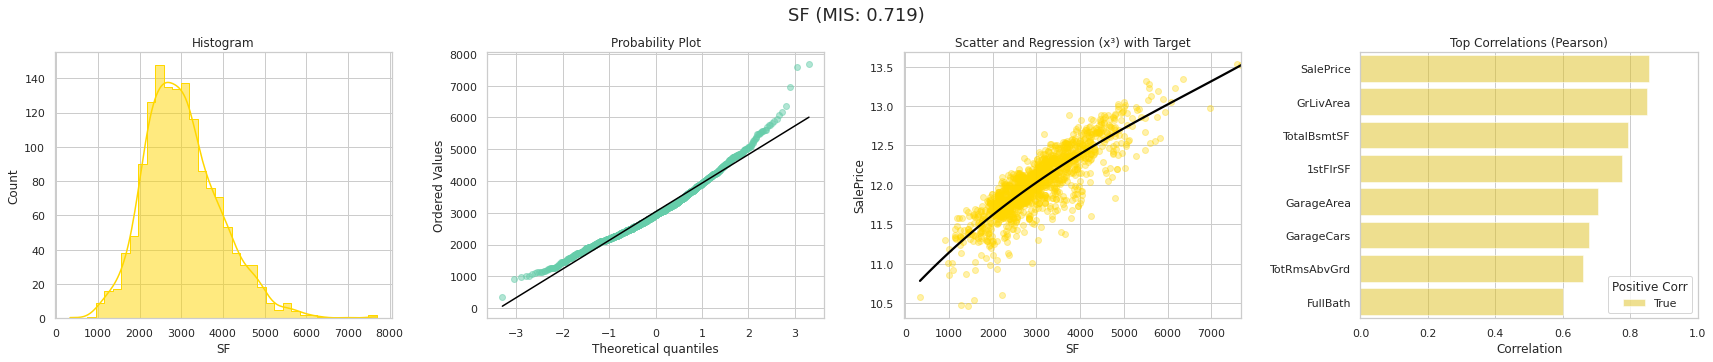

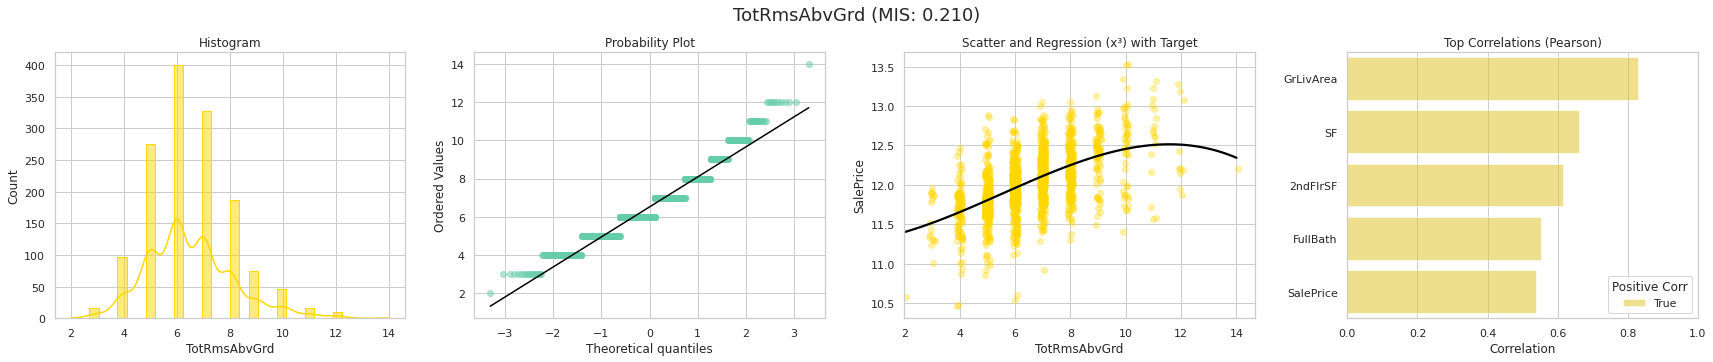

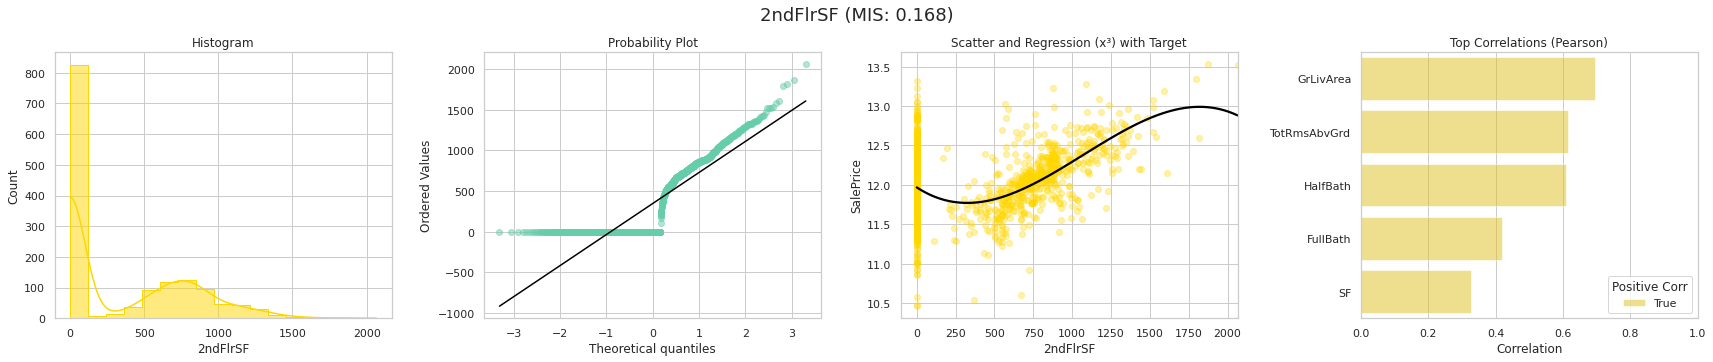

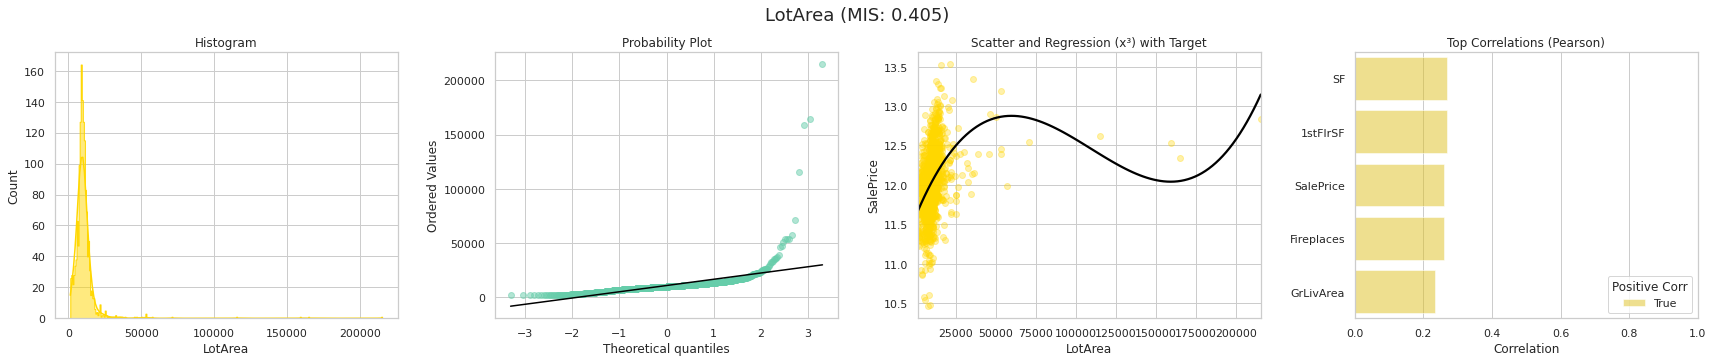

In [74]:
plot_set(train, target, group_size)

I tried exploring *LotArea*, but didn't find anything useful yet.

#### Group: Basement

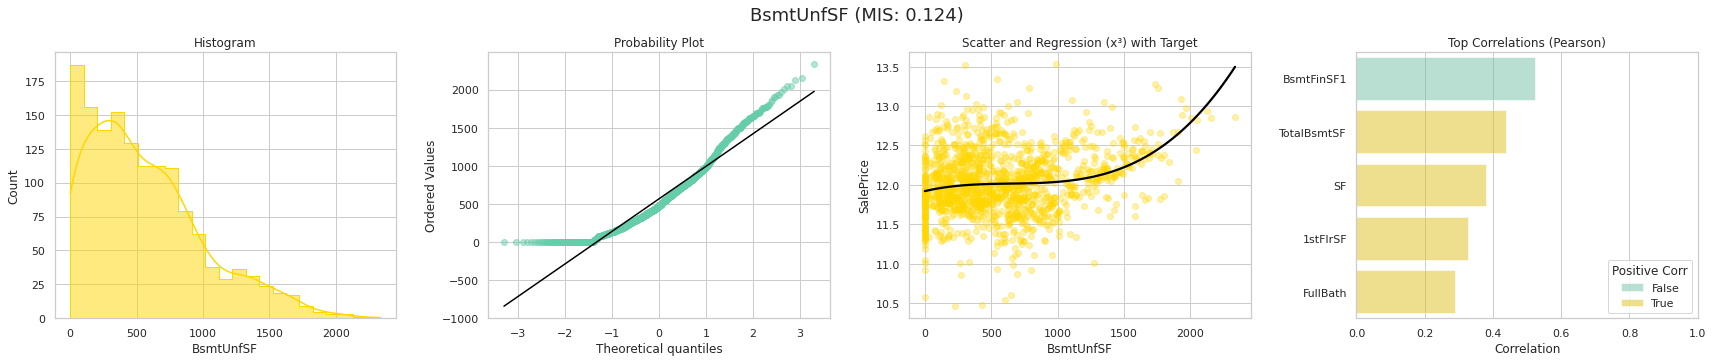

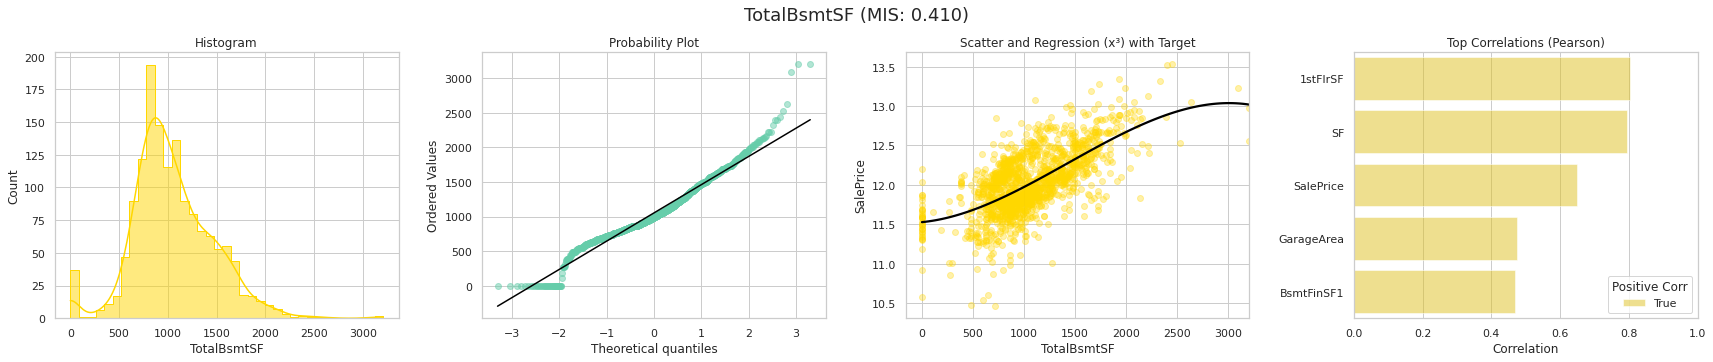

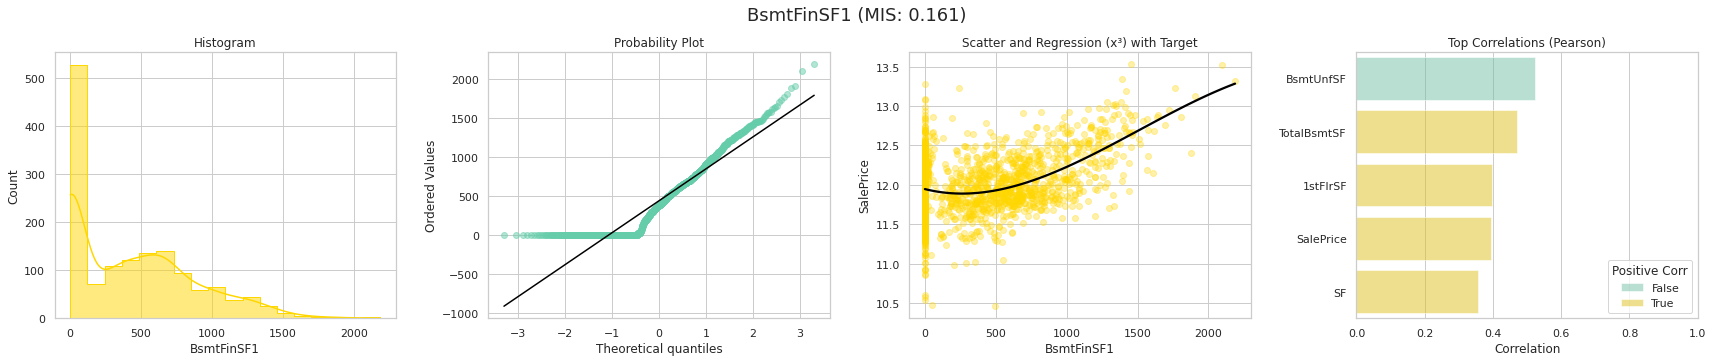

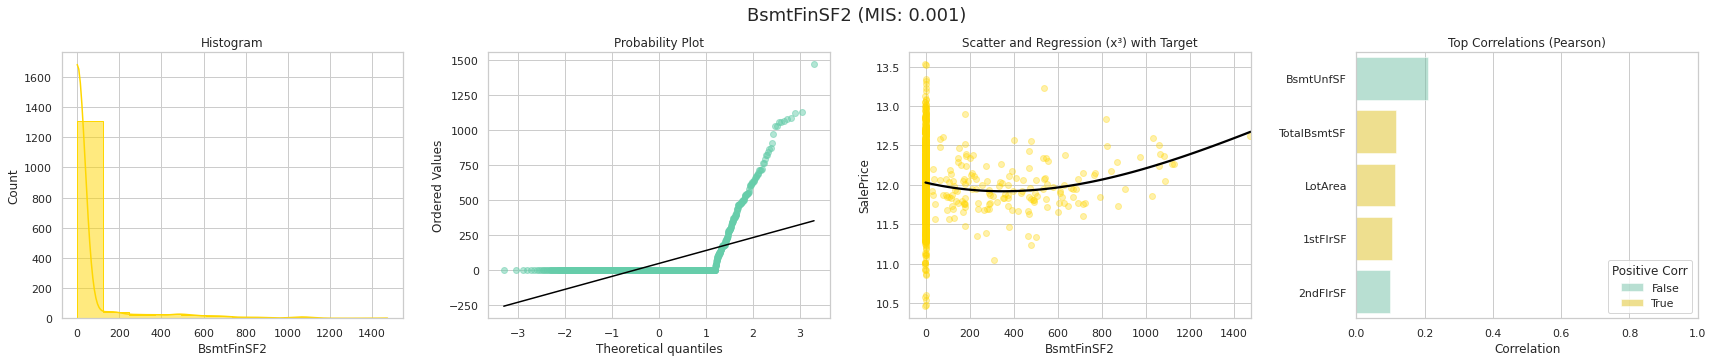

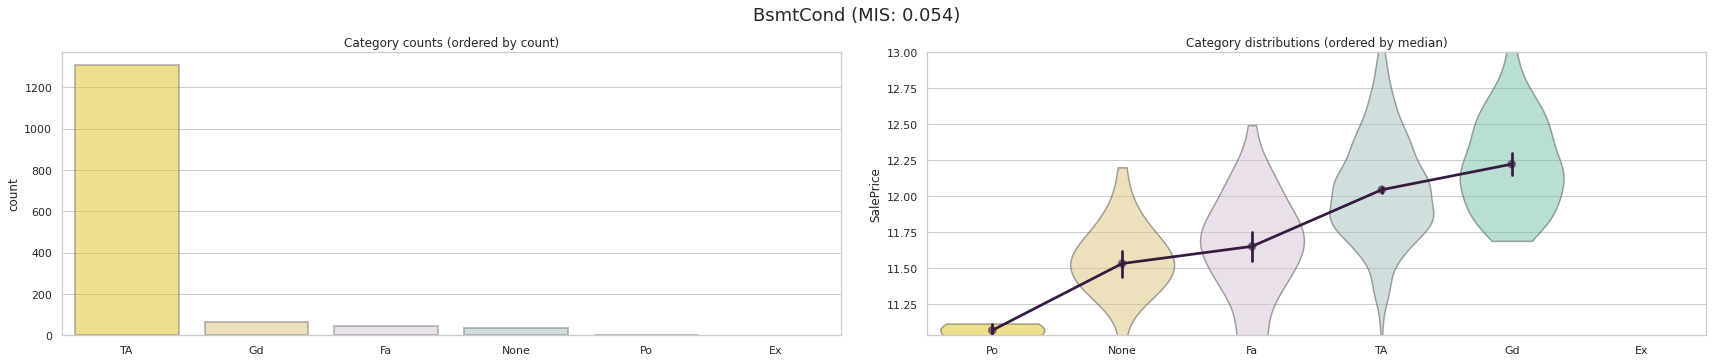

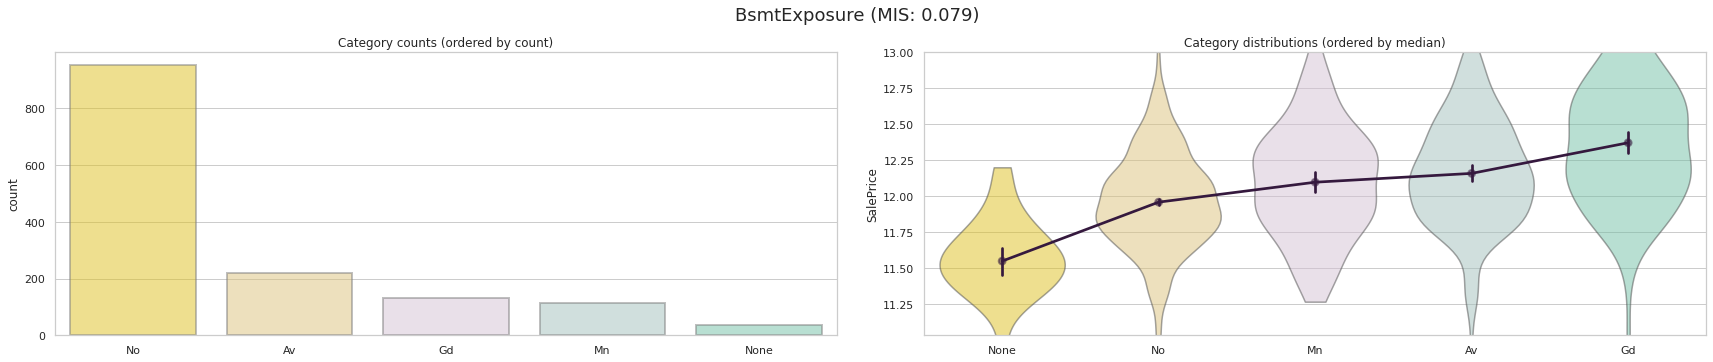

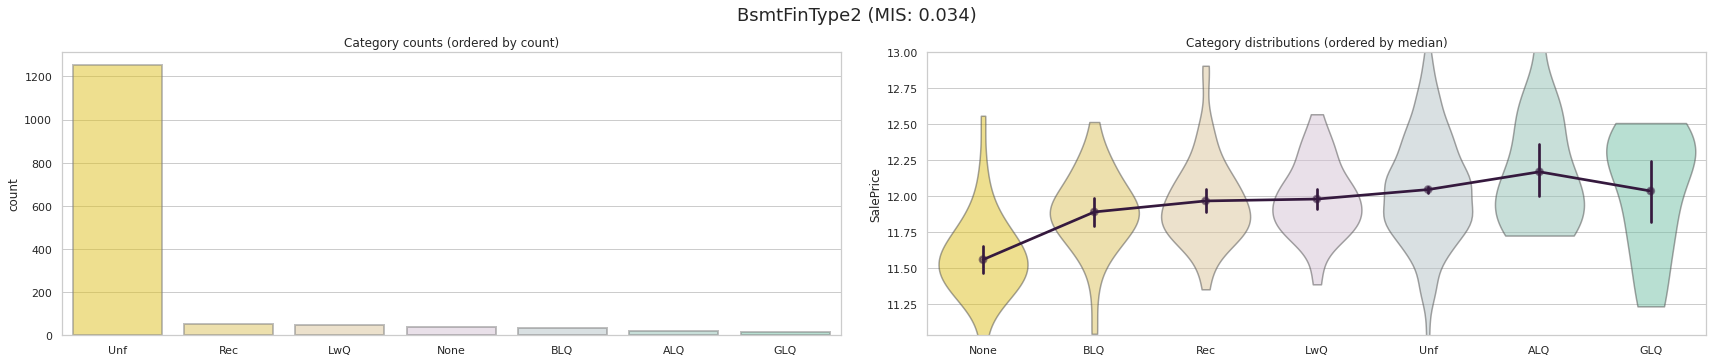

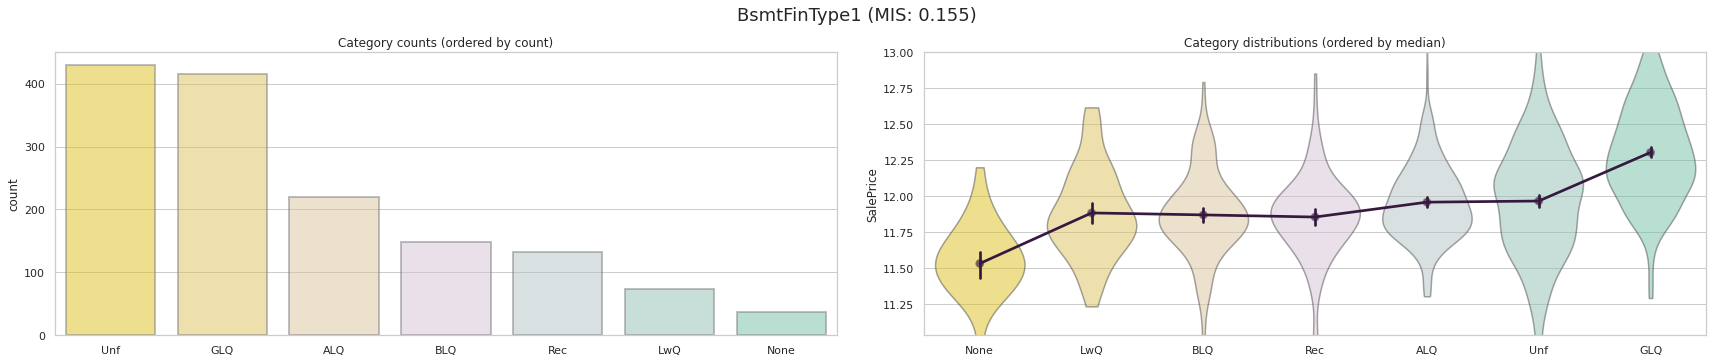

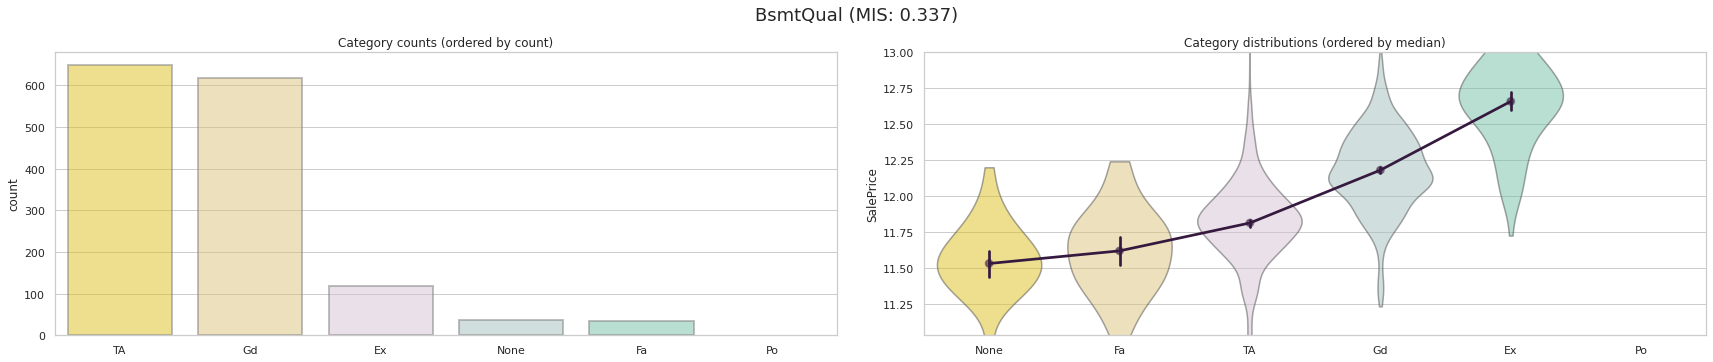

In [75]:
plot_set(train, target, group_bsmt)

*BsmtFinType* basically describes how comfortable the basement is to live in.
<br>I'll try using *BsmtFinType1 and 2* to emphasize *BsmtFinSF1 and 2*.

In [76]:
compare_score(train.assign(BS1 = lambda x: (train.BsmtFinType1.cat.codes * train.BsmtFinSF1),
                           BS2 = lambda x: (train.BsmtFinType2.cat.codes * train.BsmtFinSF2)))

Lowest RMSE     0.12764
New RMSE        0.12551
Better by       0.00213


In [77]:
compare_score(train.assign(BS1 = lambda x: (train.BsmtFinType1.cat.codes * train.BsmtFinSF1),
                           BS2 = lambda x: (train.BsmtFinType2.cat.codes * train.BsmtFinSF2))
                   .drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2'], axis=1))

Lowest RMSE     0.12764
New RMSE        0.12431
Better by       0.00333


It seems these new composites capture enough information to warrant dropping their constituents.

In [78]:
train = (train.assign(BsmtFin1 = lambda x: (train.BsmtFinType1.cat.codes * train.BsmtFinSF1),
                      BsmtFin2 = lambda x: (train.BsmtFinType2.cat.codes * train.BsmtFinSF2))
              .drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2'], axis=1))
scores['add_BsmtFin1_BsmtFin2_drop_FinType_FinSF'] = score_dataset(train, target)

I'll try the same idea with *BsmtQual* on *TotalBsmtSF*.

In [79]:
compare_score(train.assign(BsmtSFQual = lambda x: (train.BsmtQual.cat.codes * train.TotalBsmtSF)))

Lowest RMSE     0.12431
New RMSE        0.12367
Better by       0.00064


In [80]:
train = train.assign(BsmtSFQual = lambda x: (train.BsmtQual.cat.codes * train.TotalBsmtSF))
scores['add_BsmtSFQual'] = score_dataset(train, target)

#### Group: Garage

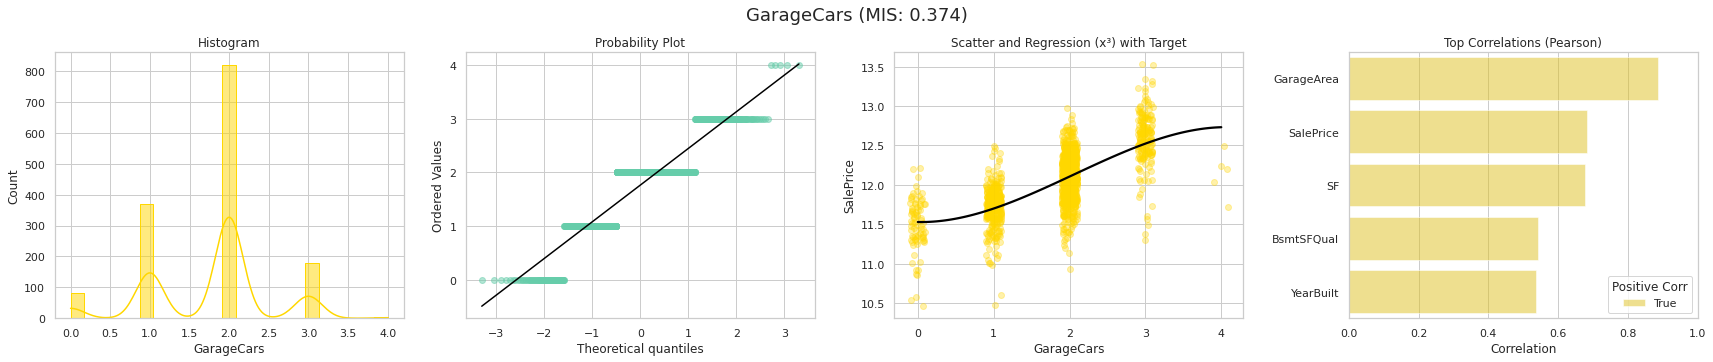

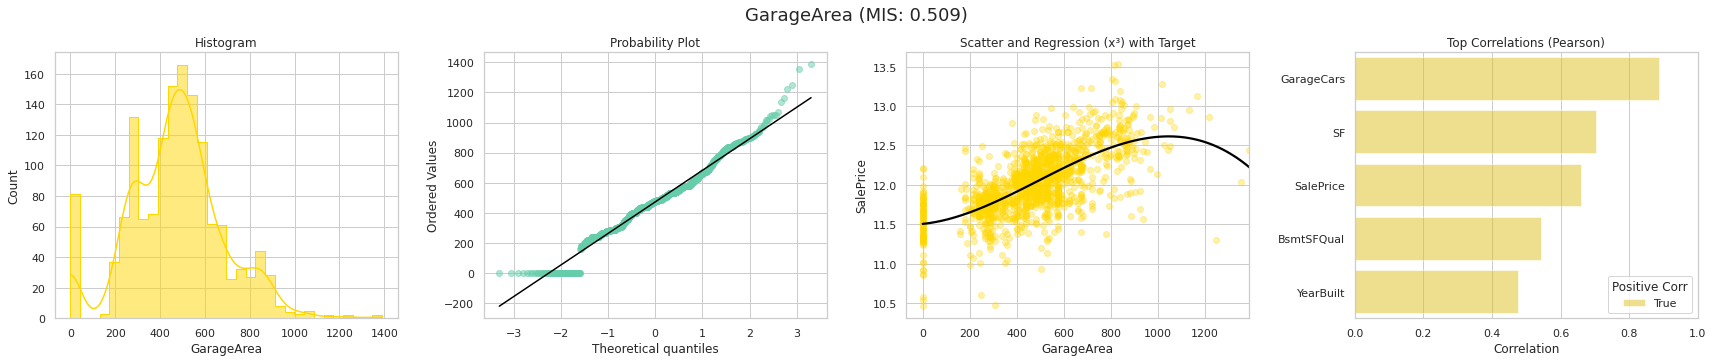

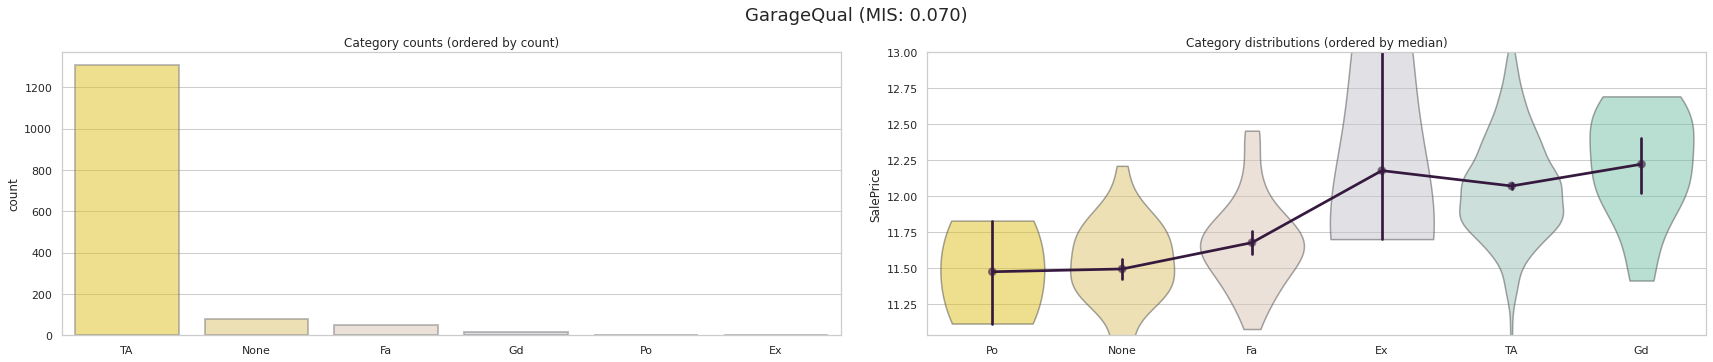

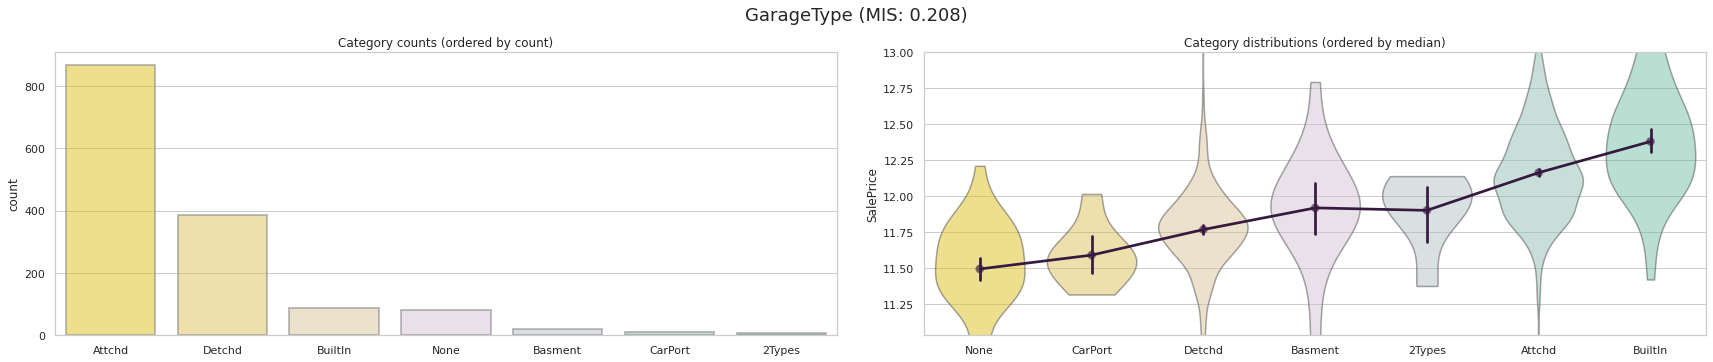

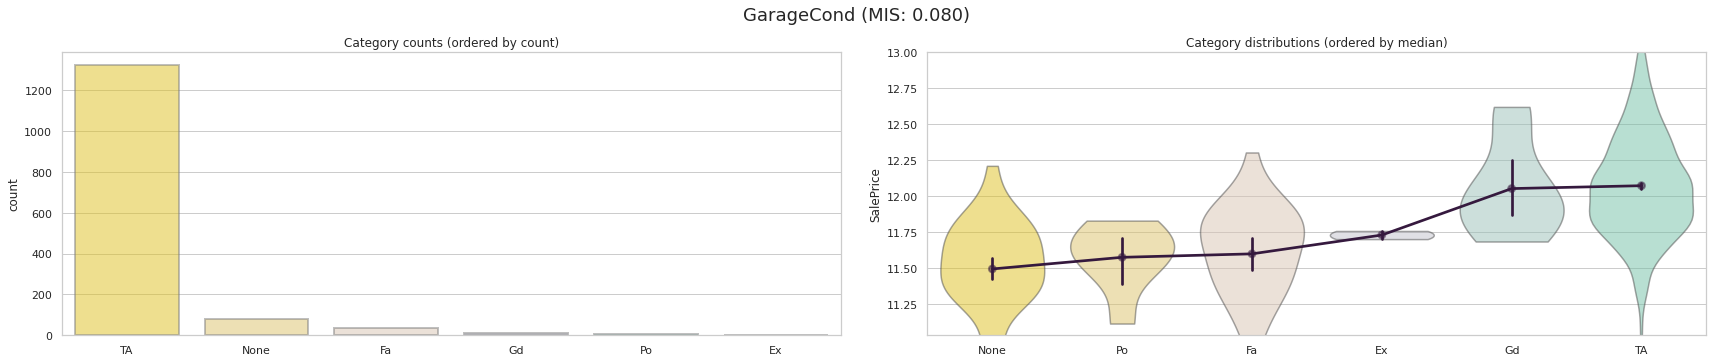

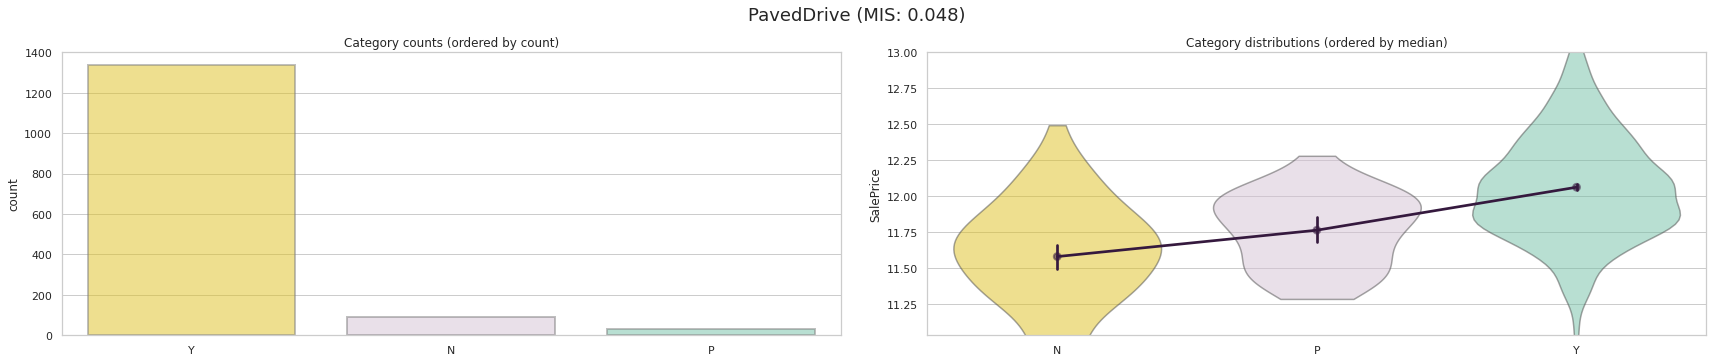

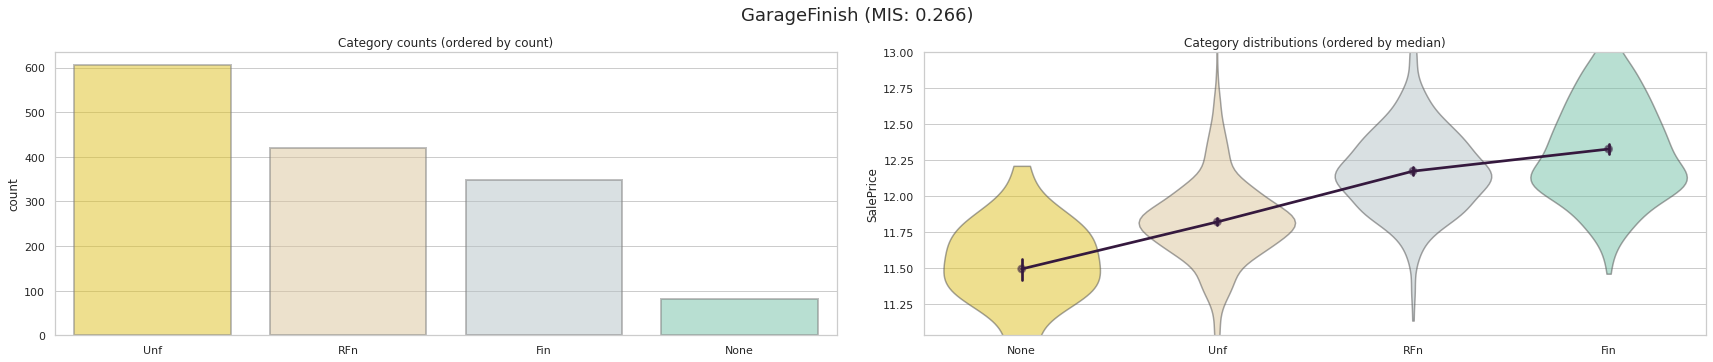

In [81]:
plot_set(train, target, group_garage)

In [82]:
compare_score(train.assign(GarageFinishCars = lambda x: train.GarageFinish.cat.codes * train.GarageCars))

Lowest RMSE     0.12367
New RMSE        0.12231
Better by       0.00135


In [83]:
compare_score(train.assign(GarageFinishCars = lambda x: train.GarageFinish.cat.codes * train.GarageCars).drop('GarageCars', axis=1))

Lowest RMSE     0.12367
New RMSE        0.12139
Better by       0.00228


In [84]:
train = (train.assign(GarageFinishCars = lambda x: train.GarageFinish.cat.codes * train.GarageCars)
              .drop('GarageCars', axis=1))
scores['add_GarageFinishCars_drop_GarageCars'] = score_dataset(train, target)

#### Group: Property

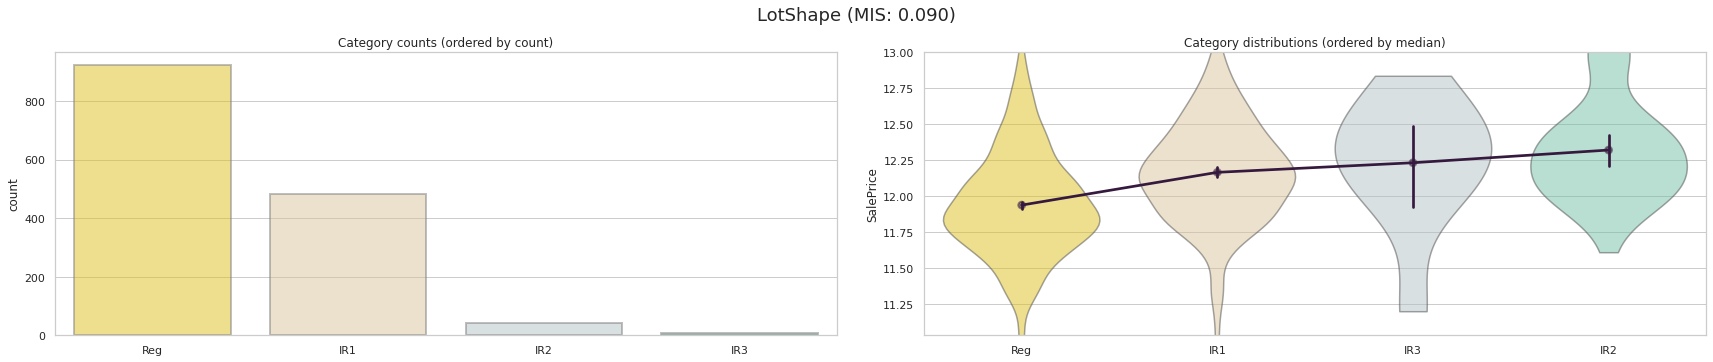

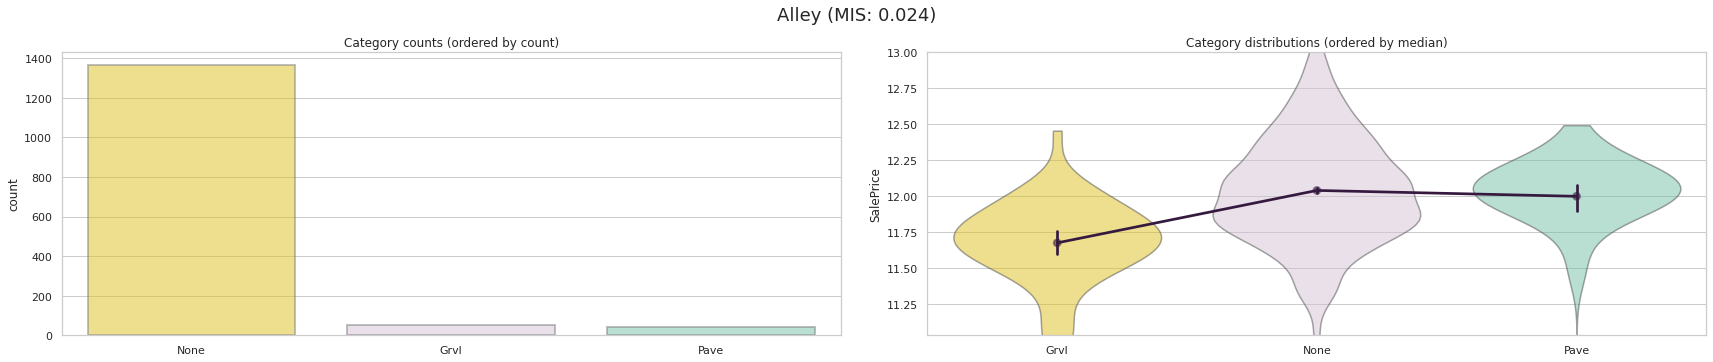

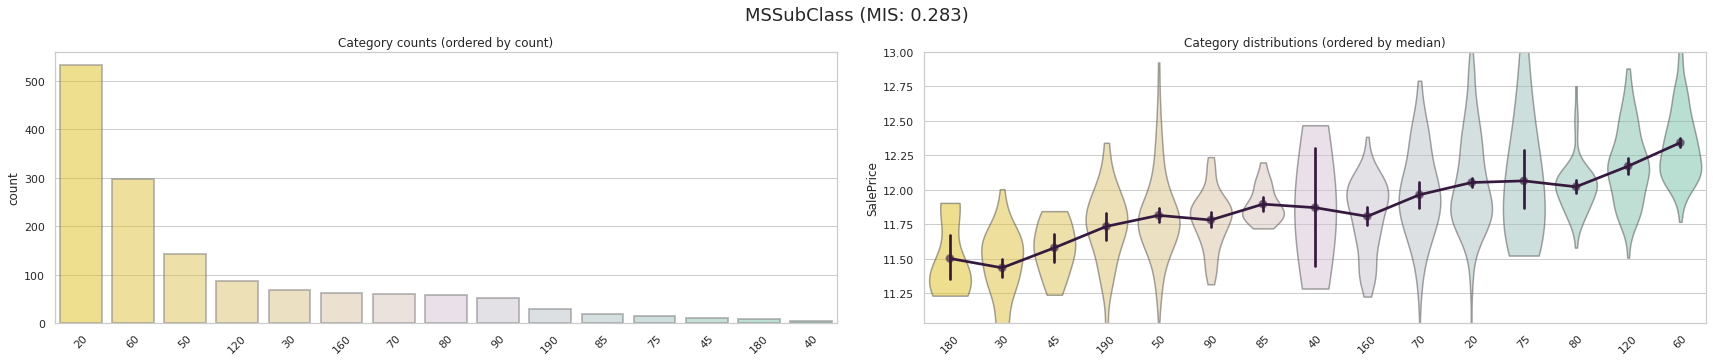

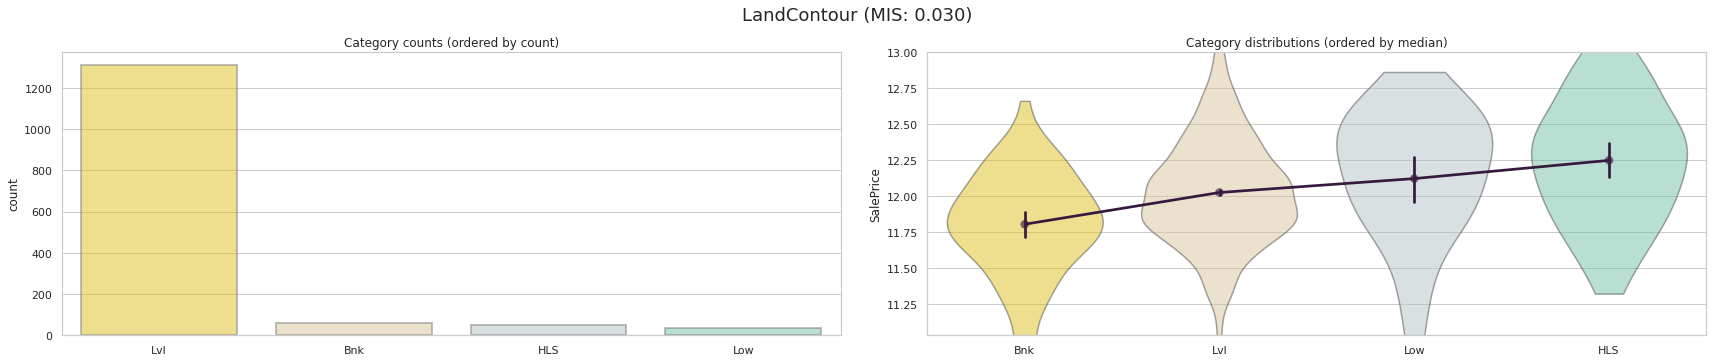

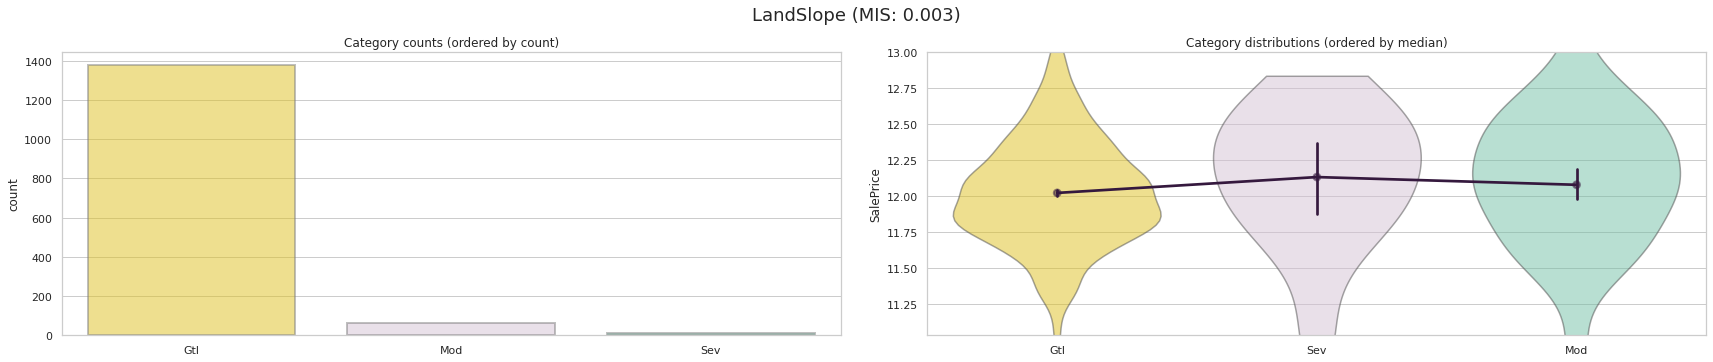

In [85]:
plot_set(train, target, group_property)

I investigated *MSSubClass* as it distributes well across *SalePrice*, but didn't find anything useful.

#### Group: External

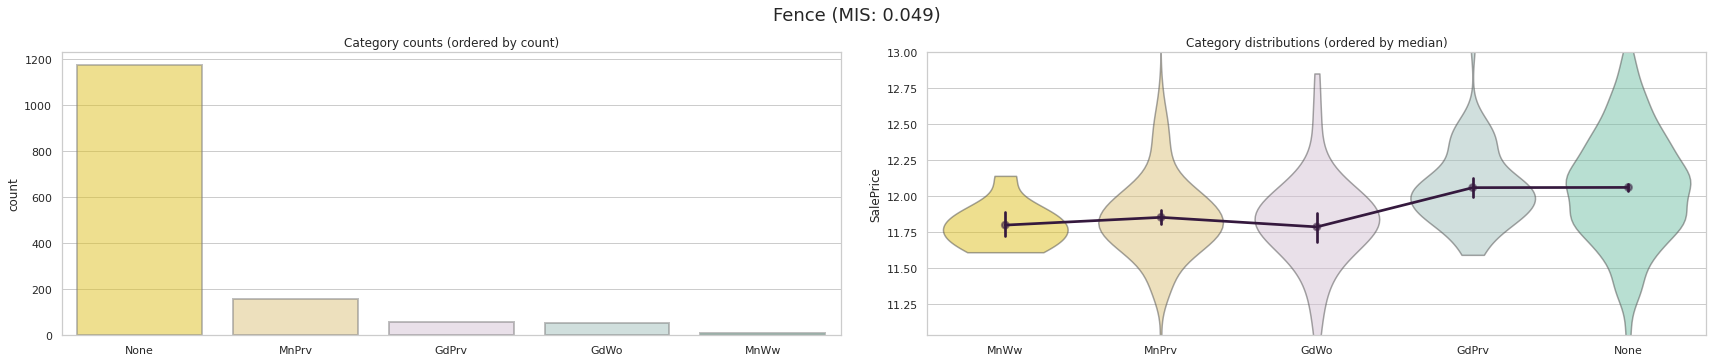

In [86]:
plot_set(train, target, group_external)

#### Group: Exterior

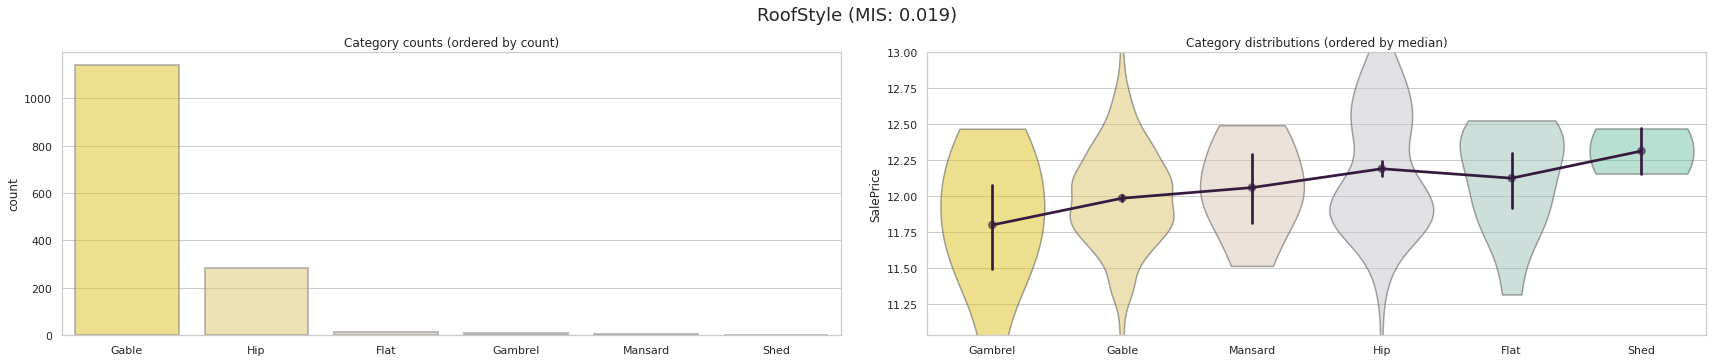

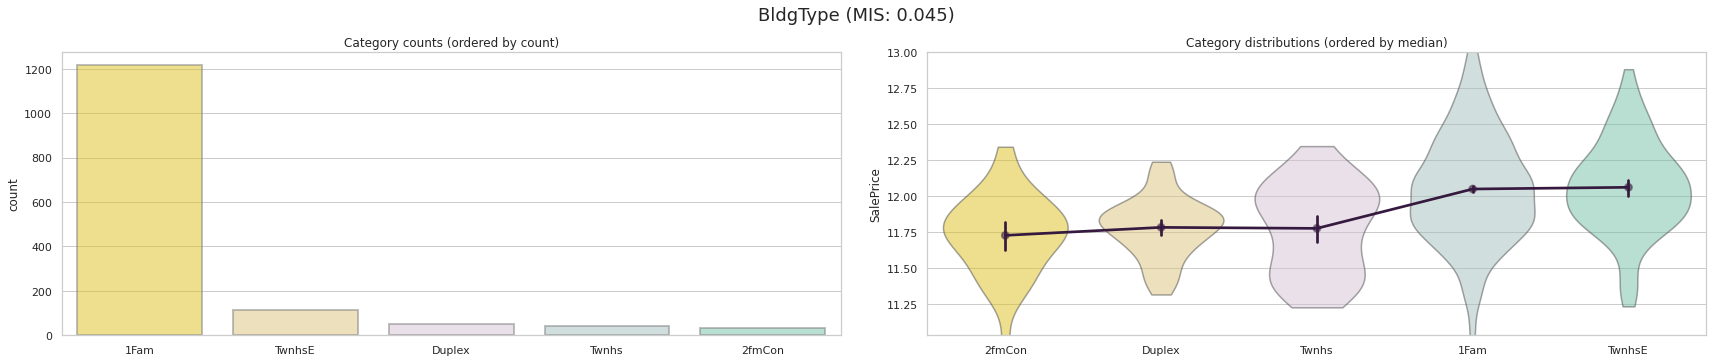

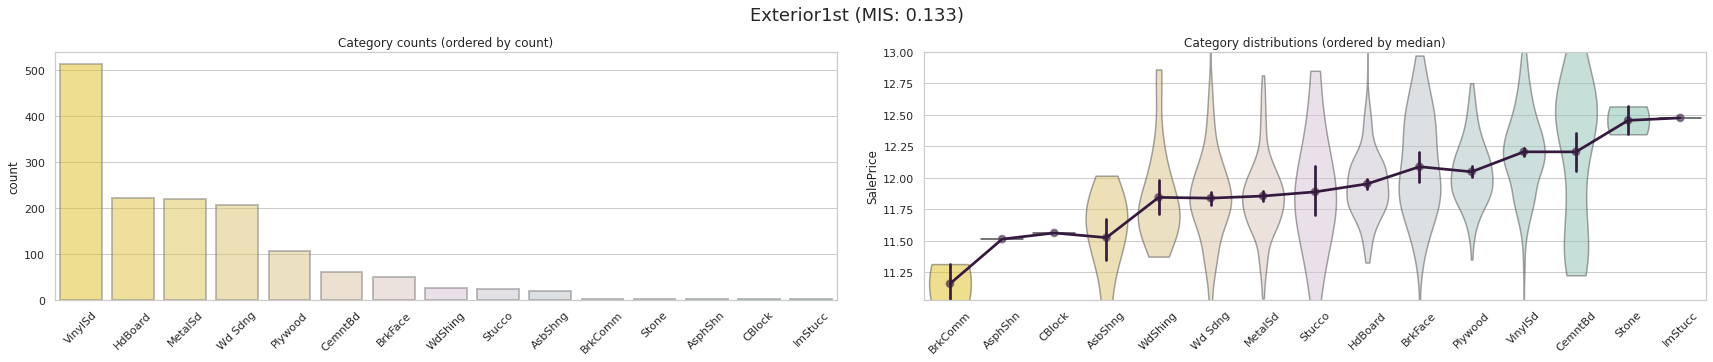

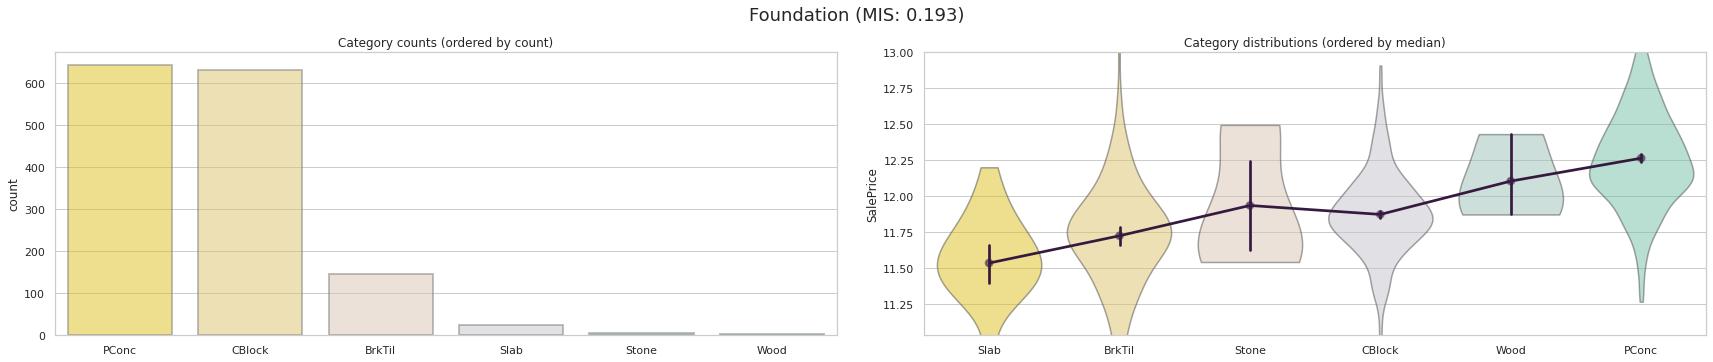

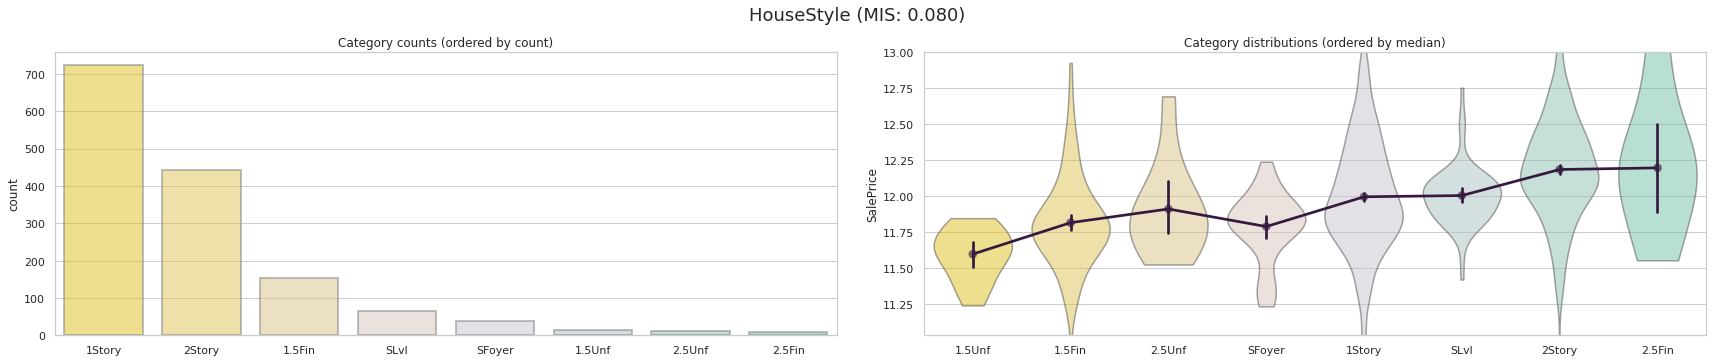

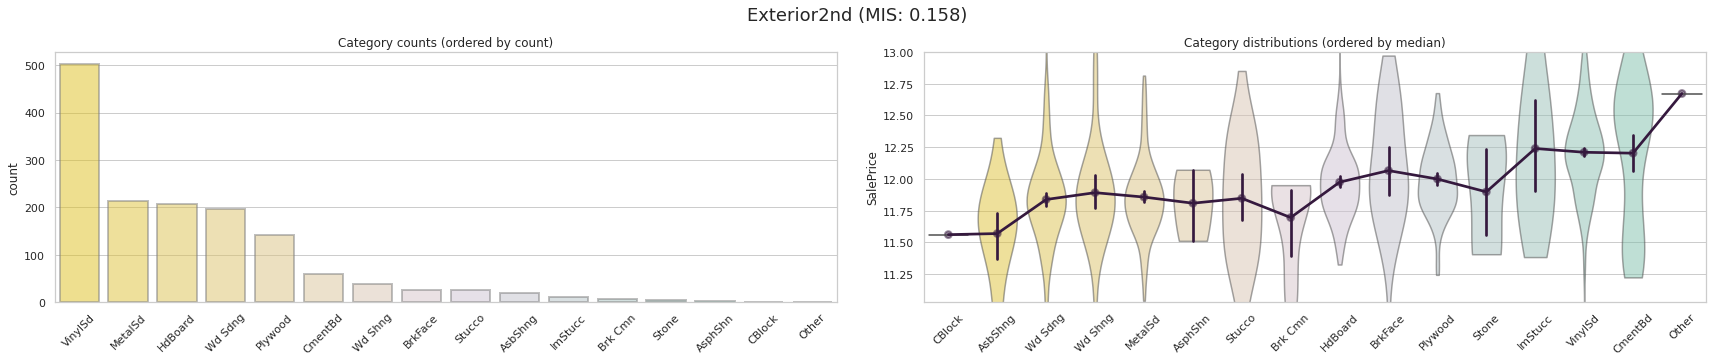

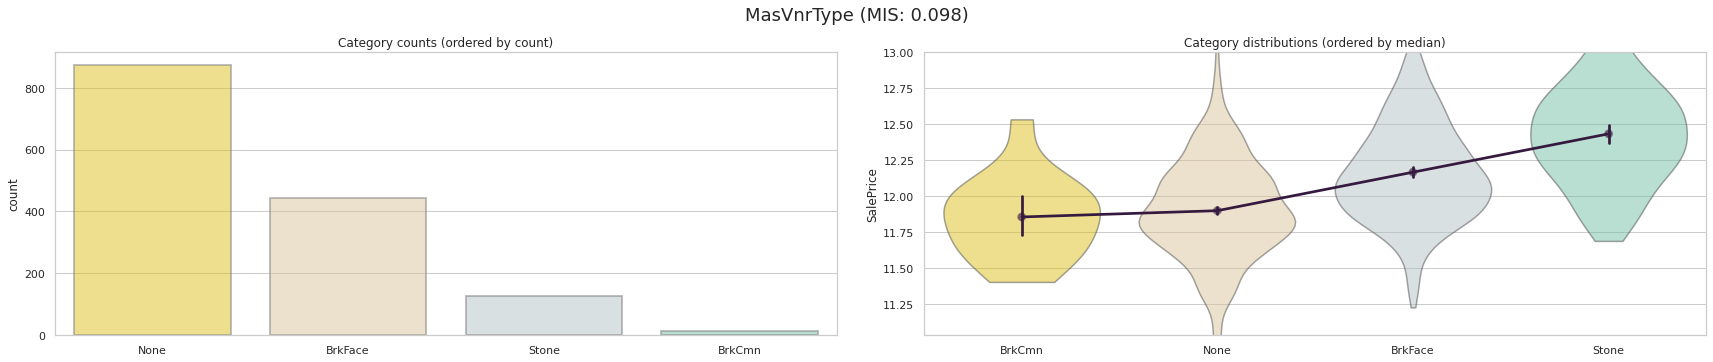

In [87]:
plot_set(train, target, group_exterior)

#### Group: Interior

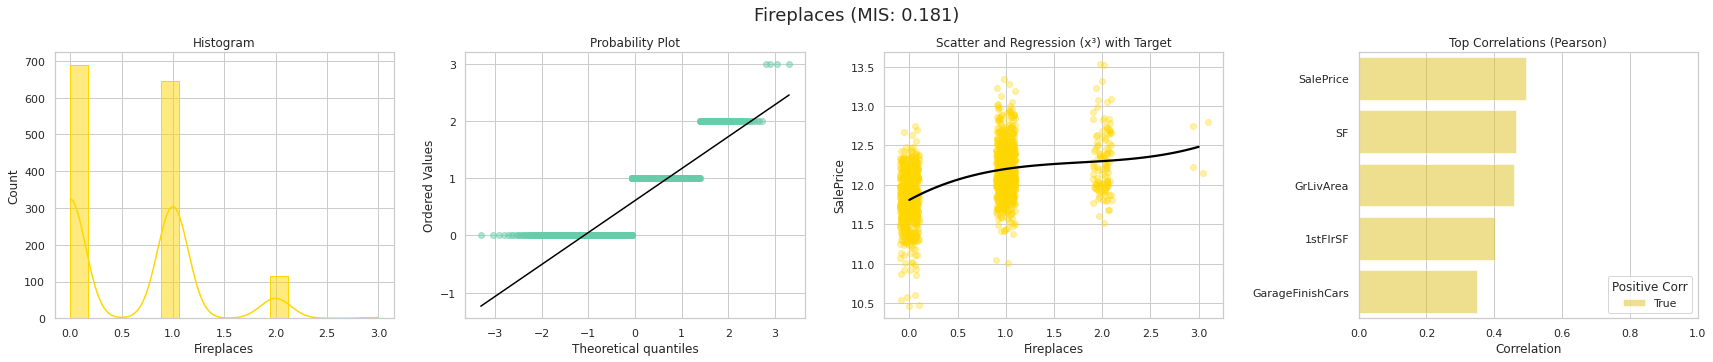

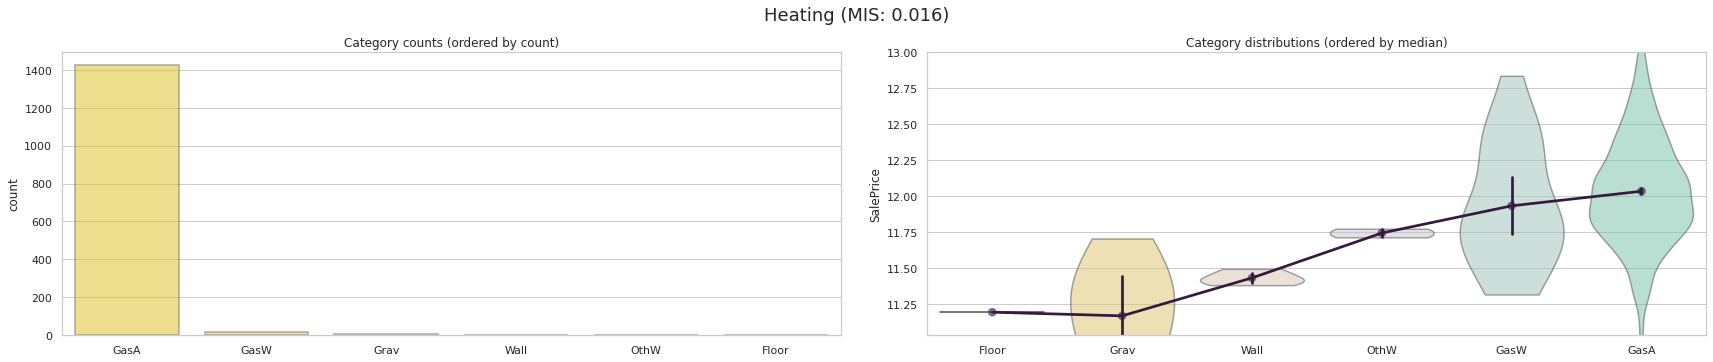

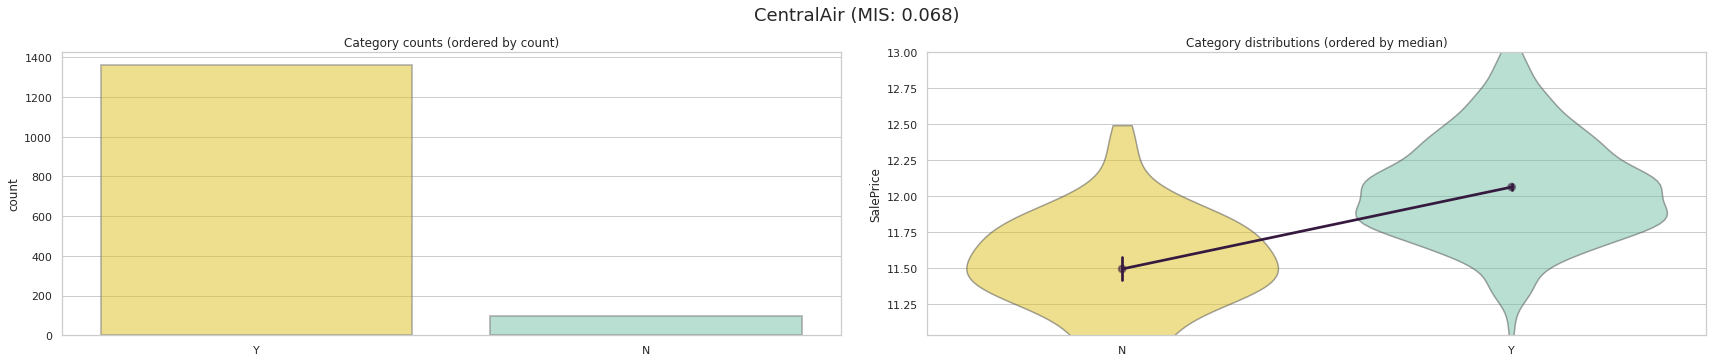

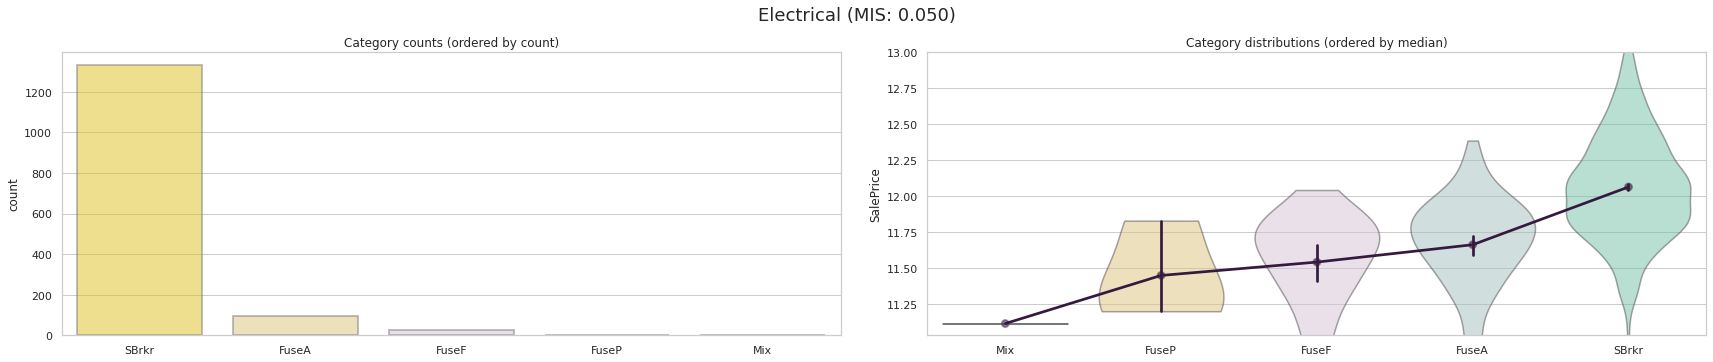

In [88]:
plot_set(train, target, group_interior)

#### Group: Quality and Condition

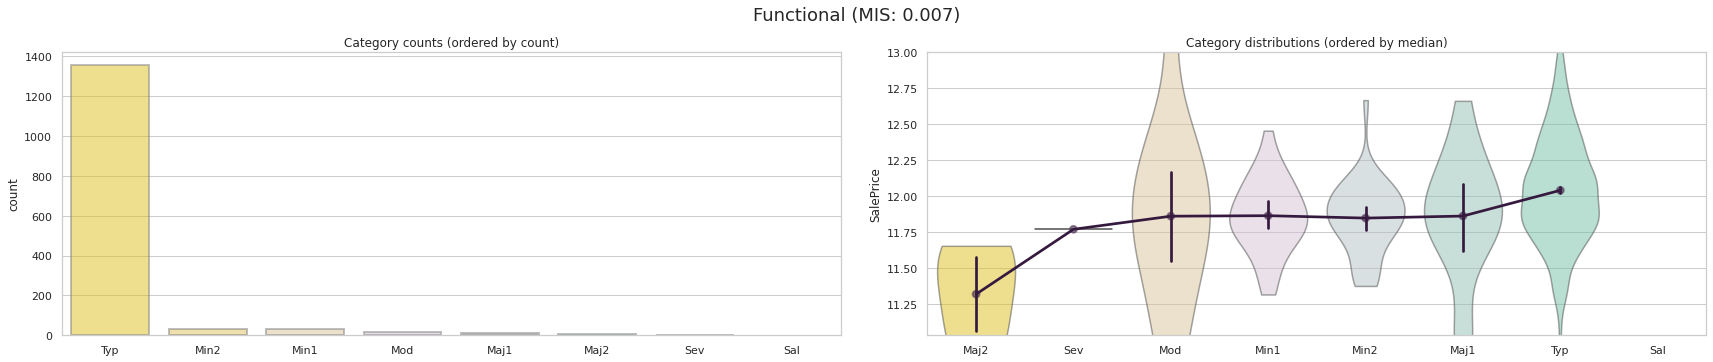

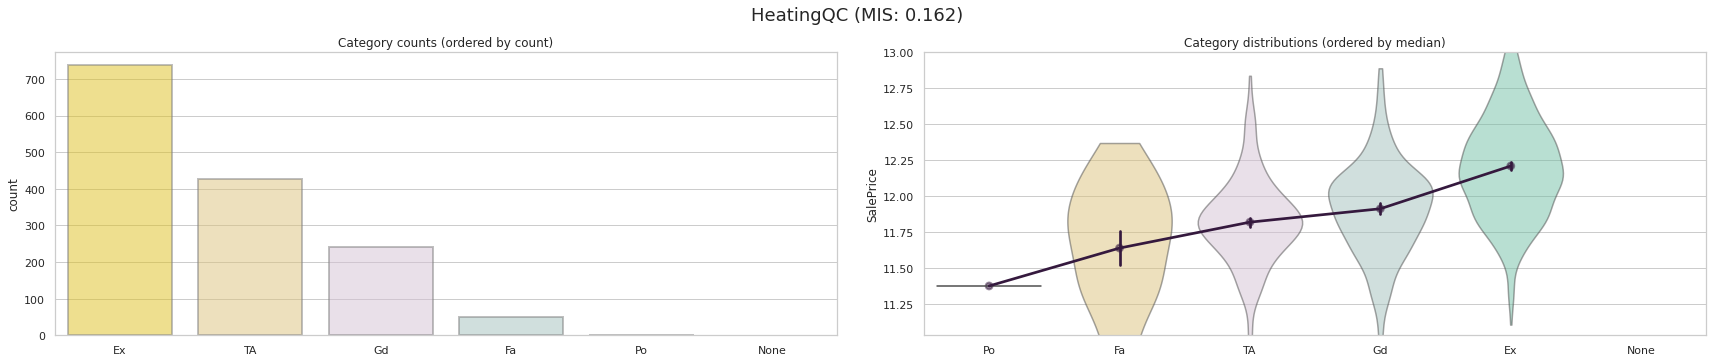

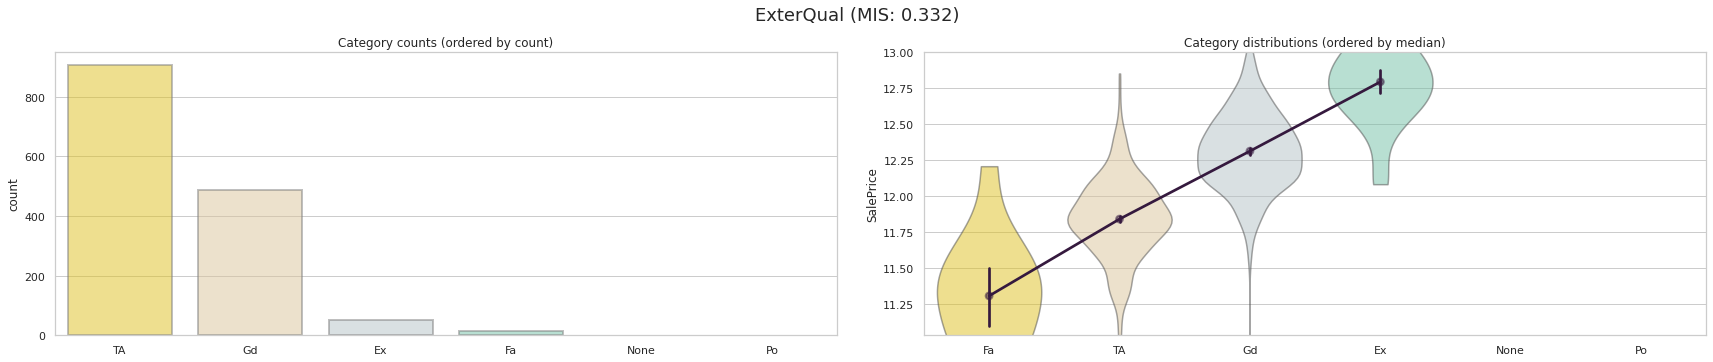

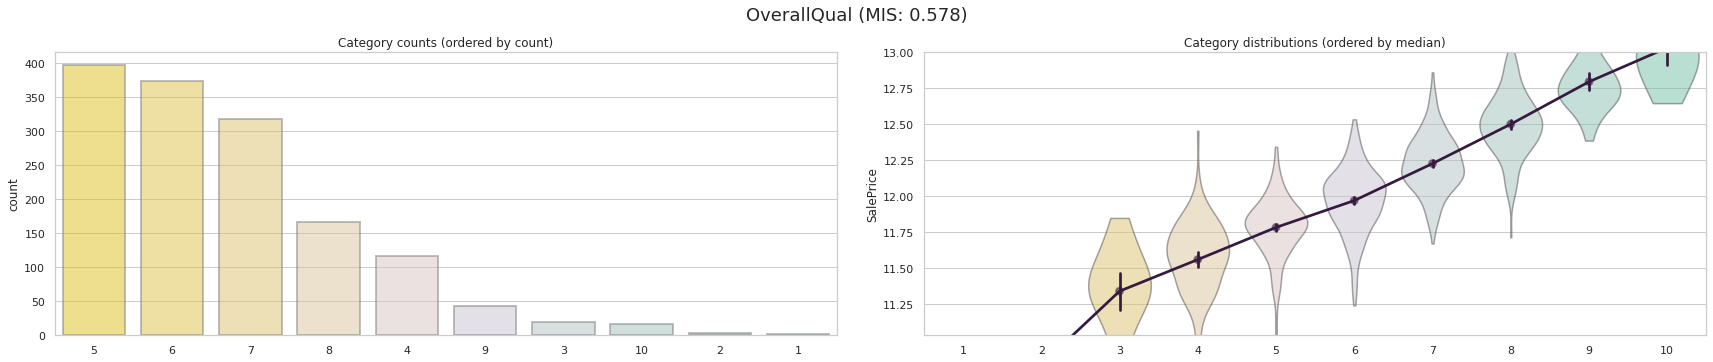

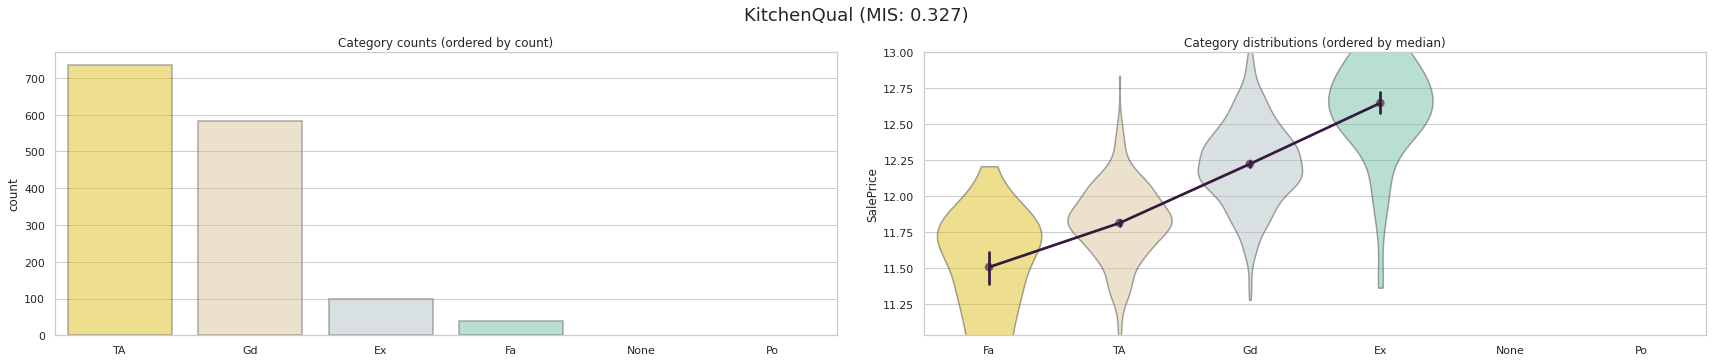

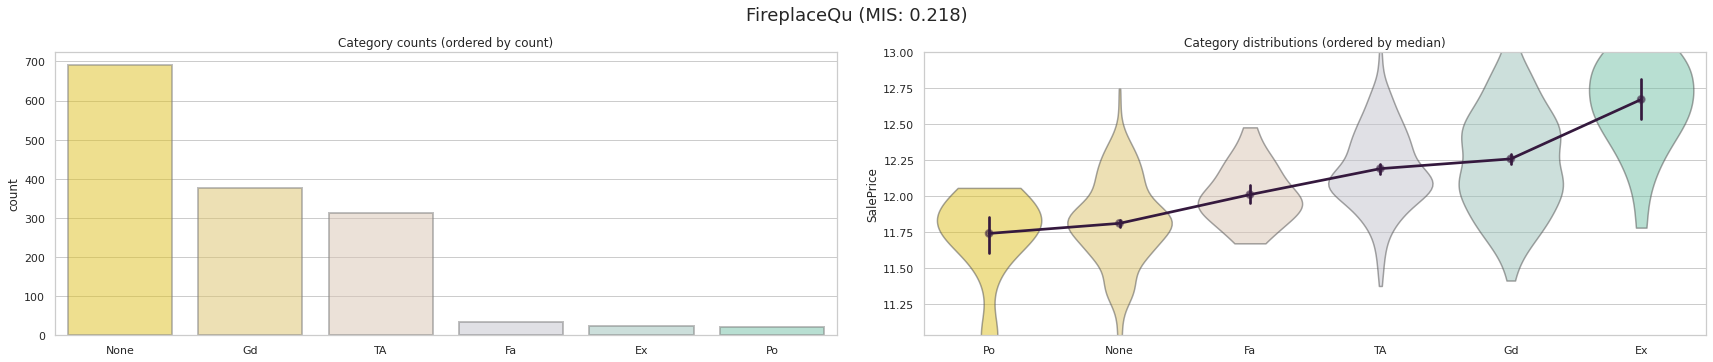

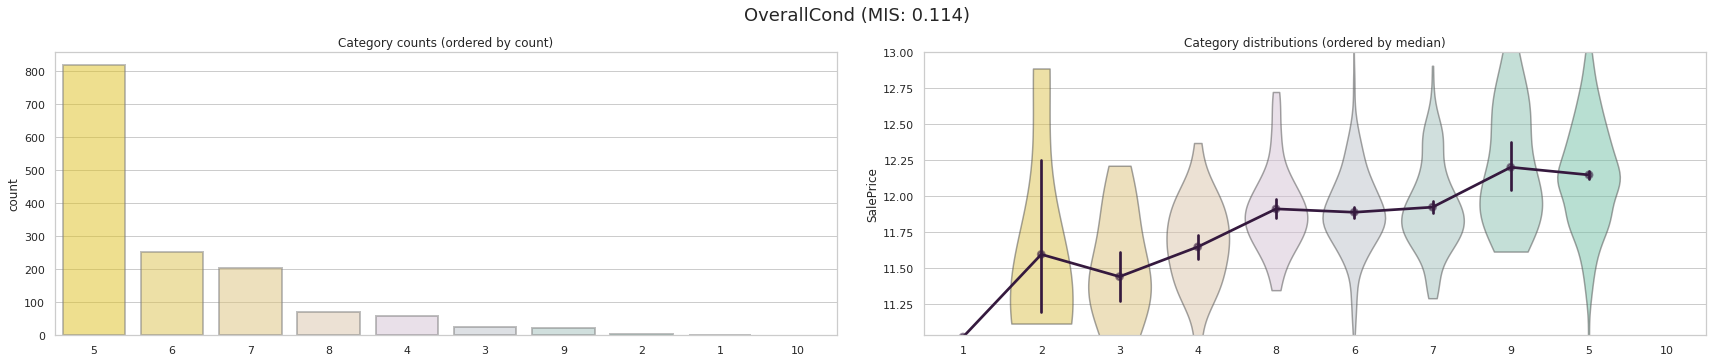

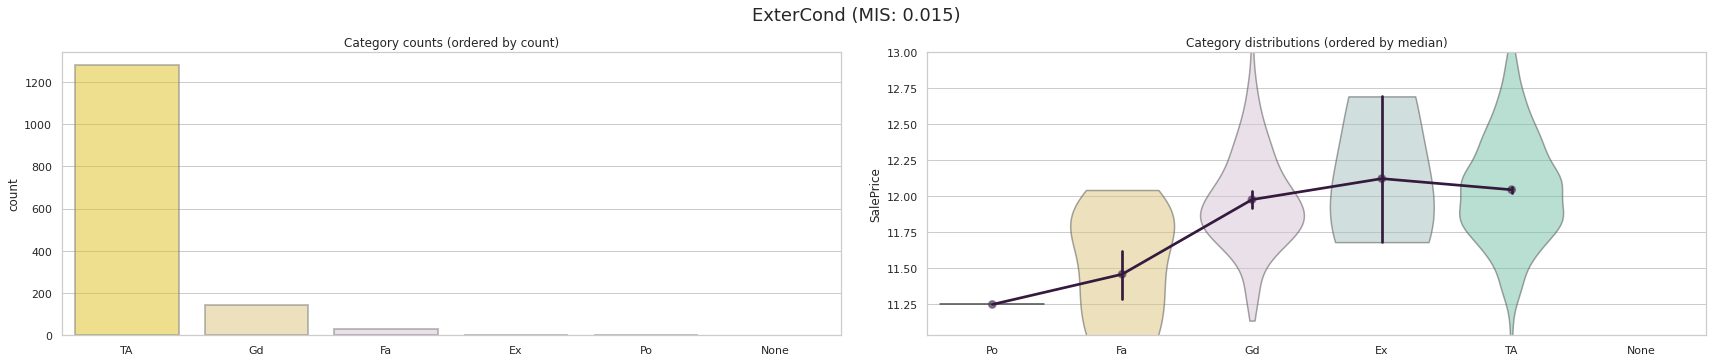

In [89]:
plot_set(train, target, group_qc)

I've omitted a lot of trial and error, looking for feature combinations.  
The takeaway is that many combinations that may seem intuitive do not seem to be informative.  
For instance, I would have expected *OverallQual* combined with total indoor surface area *SF* to be informative.  
My reasoning being "having more of a good thing".

In [90]:
compare_score(train.assign(IntuitiveFeature=lambda x: train.OverallQual.cat.codes * train.SF))

Lowest RMSE     0.12139
New RMSE        0.12601
Worse by        0.00462


Whereas, a combination I tried by chance seems helpful yet unintuitive.

In [91]:
compare_score(train.assign(KitchenQualOverallCond=lambda x: train.KitchenQual.cat.codes * train.OverallCond.cat.codes))

Lowest RMSE     0.12139
New RMSE        0.11945
Better by       0.00194


In [92]:
train = train.assign(KitchenQualOverallCond=lambda x: train.KitchenQual.cat.codes * train.OverallCond.cat.codes)
scores['add_KitchenQualOverallCond'] = score_dataset(train, target)

#### Group: Bath

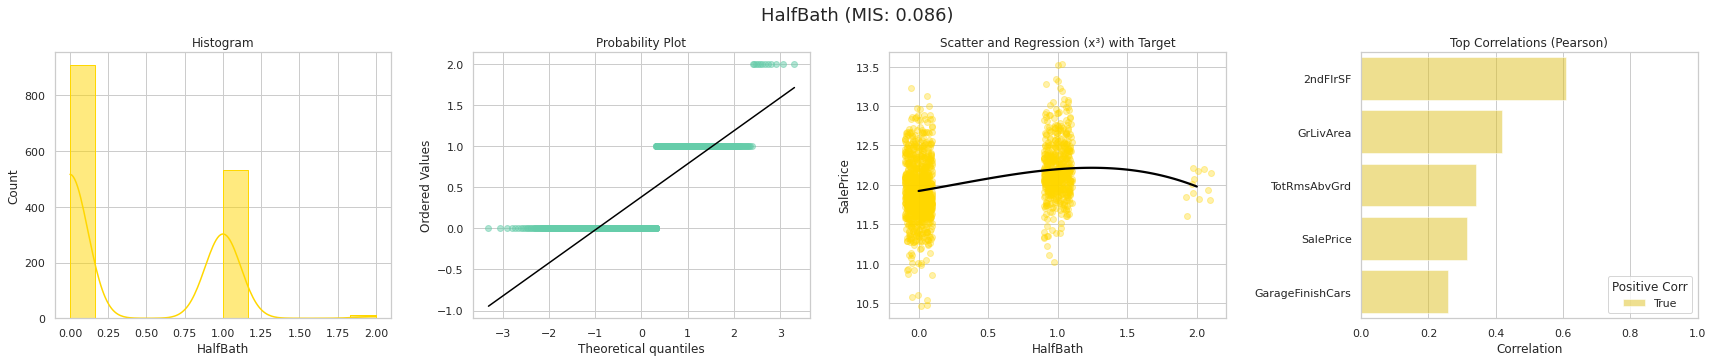

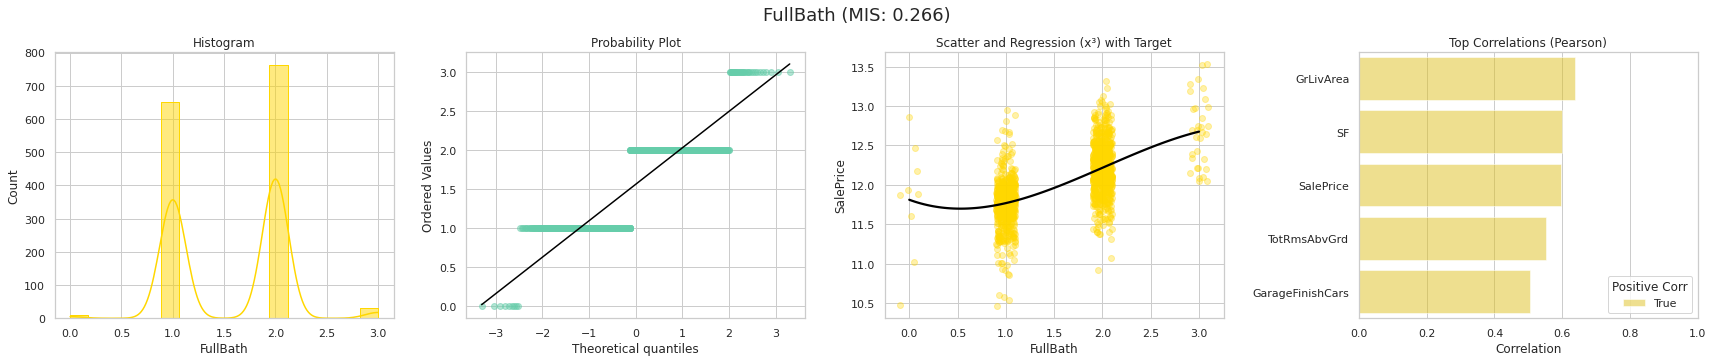

In [93]:
plot_set(train, target, group_bath)

In [94]:
compare_score(train.assign(TotalBaths=lambda x: train.FullBath + 0.5 * train.HalfBath))

Lowest RMSE     0.11945
New RMSE        0.11885
Better by       0.00059


In [95]:
train = train.assign(TotalBaths=lambda x: train.FullBath + 0.5 * train.HalfBath)
scores['add_TotalBaths'] = score_dataset(train, target)

#### Group: Other

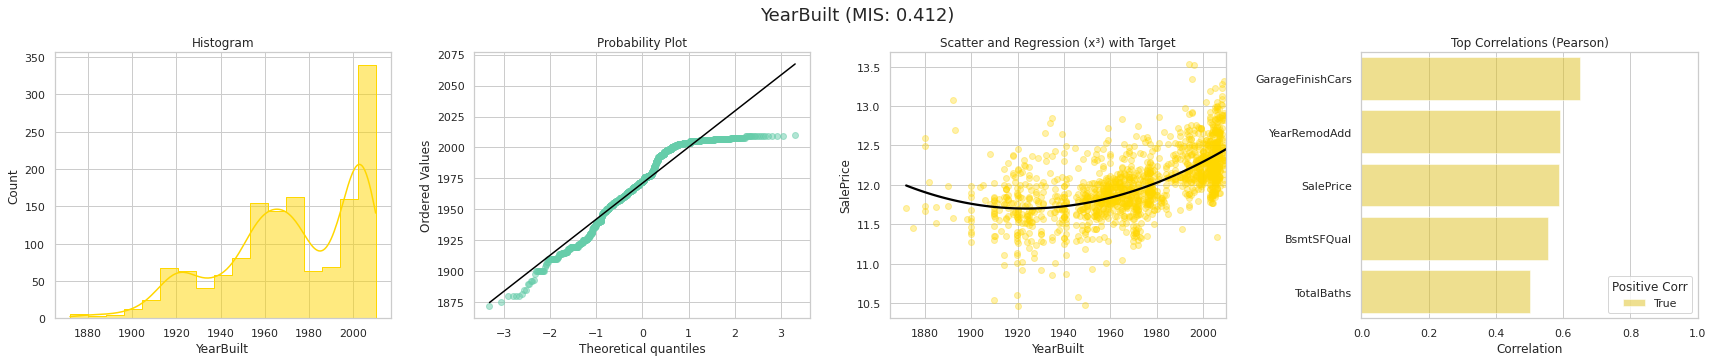

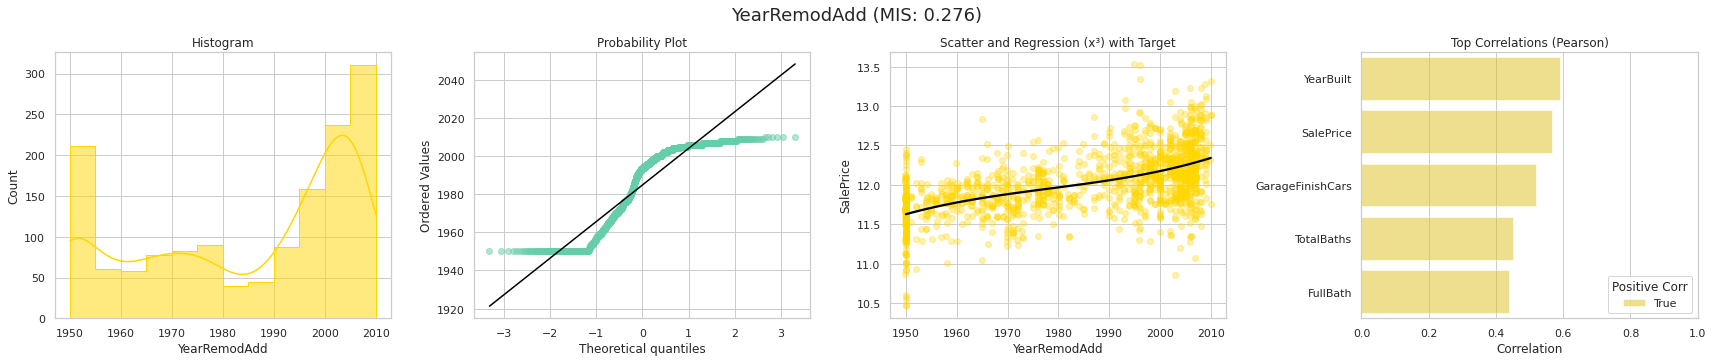

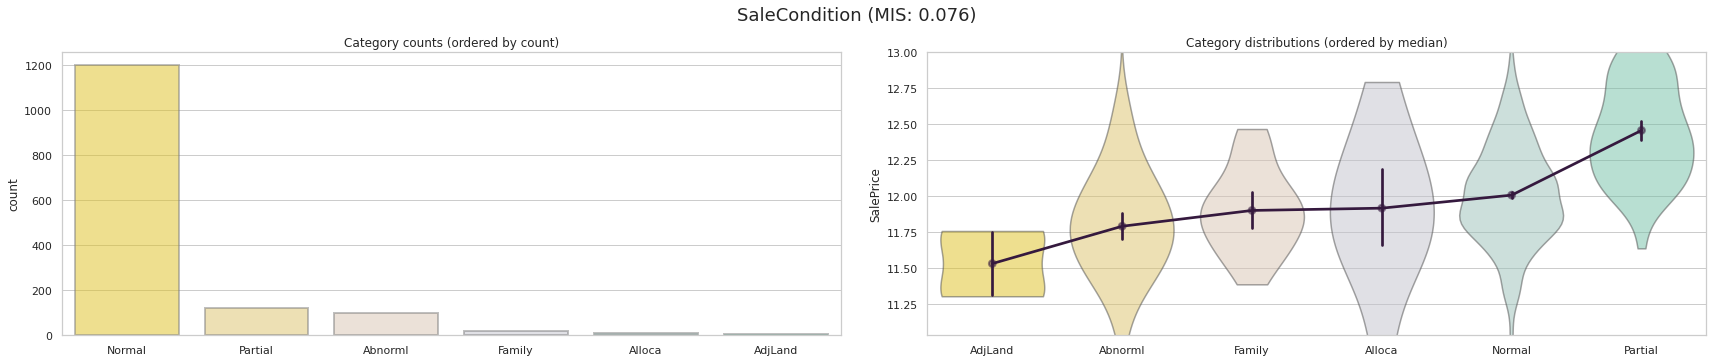

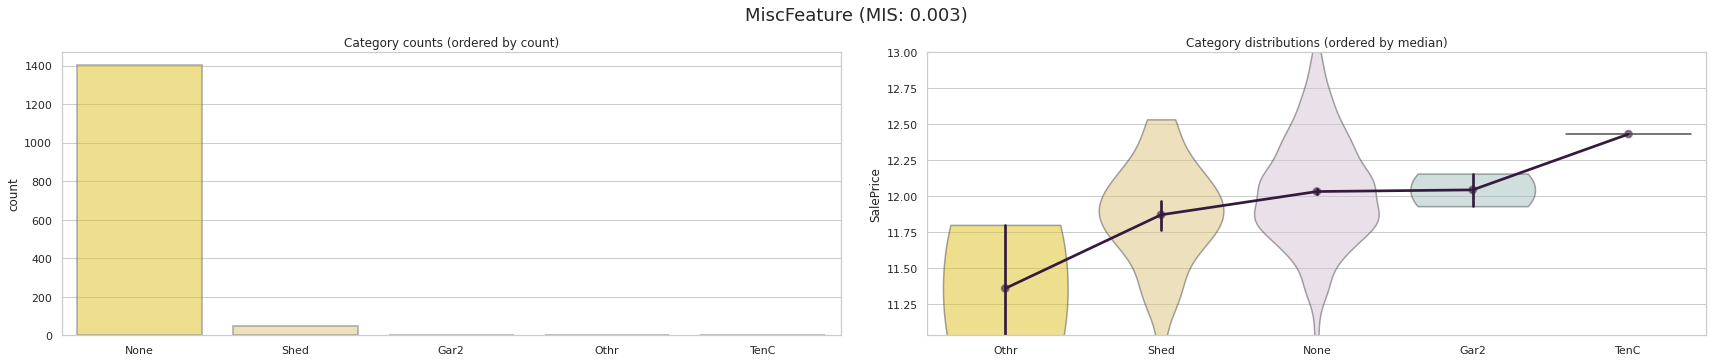

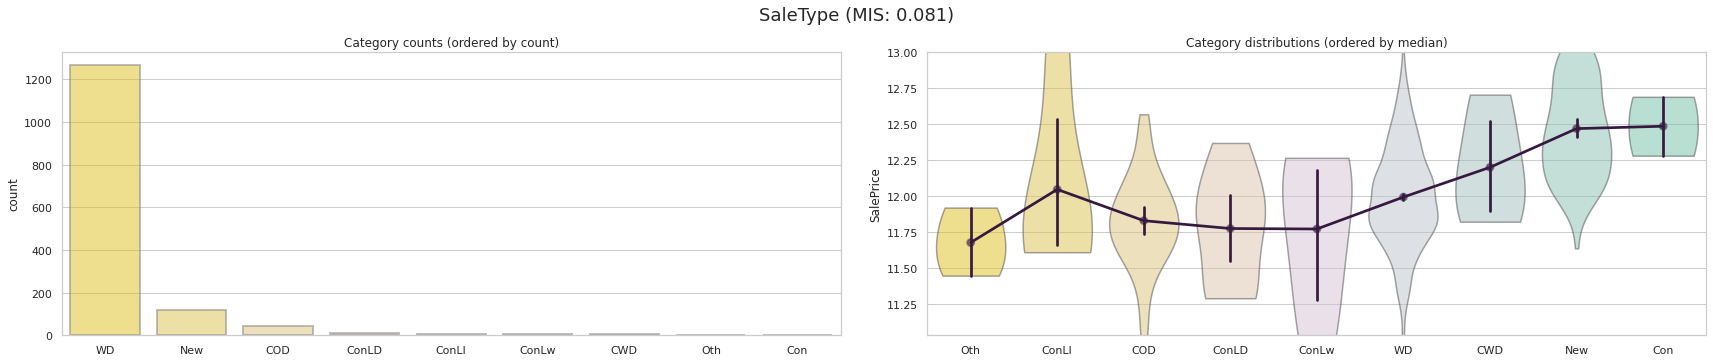

In [96]:
plot_set(train, target, group_other)

## Feature Engineering Recap
If I found any features to create or drop that improved upon the baseline score, I've included them in *train*.

In [97]:
scores

{'baseline': 0.13875698578094056,
 'sulov': 0.13306083219194825,
 'selected_drops': 0.13081064629141778,
 'add_SF': 0.13923006717367292,
 'drop_outliers_1': 0.12763966828018036,
 'add_BsmtFin1_BsmtFin2_drop_FinType_FinSF': 0.12430937295349466,
 'add_BsmtSFQual': 0.1236668174313715,
 'add_GarageFinishCars_drop_GarageCars': 0.12138596640270706,
 'add_KitchenQualOverallCond': 0.11944736146084017,
 'add_TotalBaths': 0.1188529106391557}

In [98]:
new_features = {'SF', 'BsmtFin1', 'BsmtFin2', 'BsmtSFQual', 'GarageFinishCars', 'KitchenQualOverallCond', 'TotalBaths'}

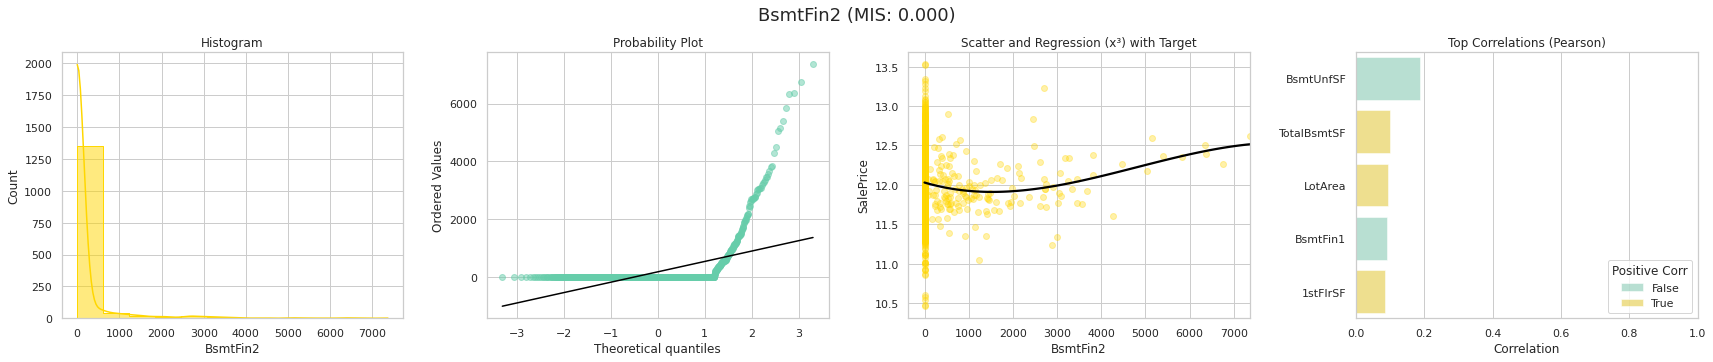

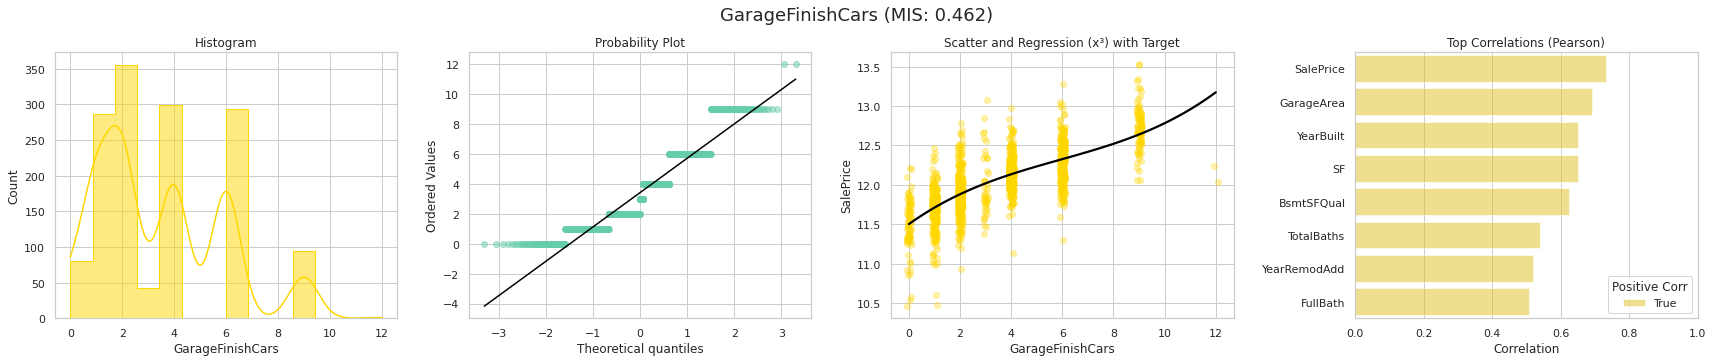

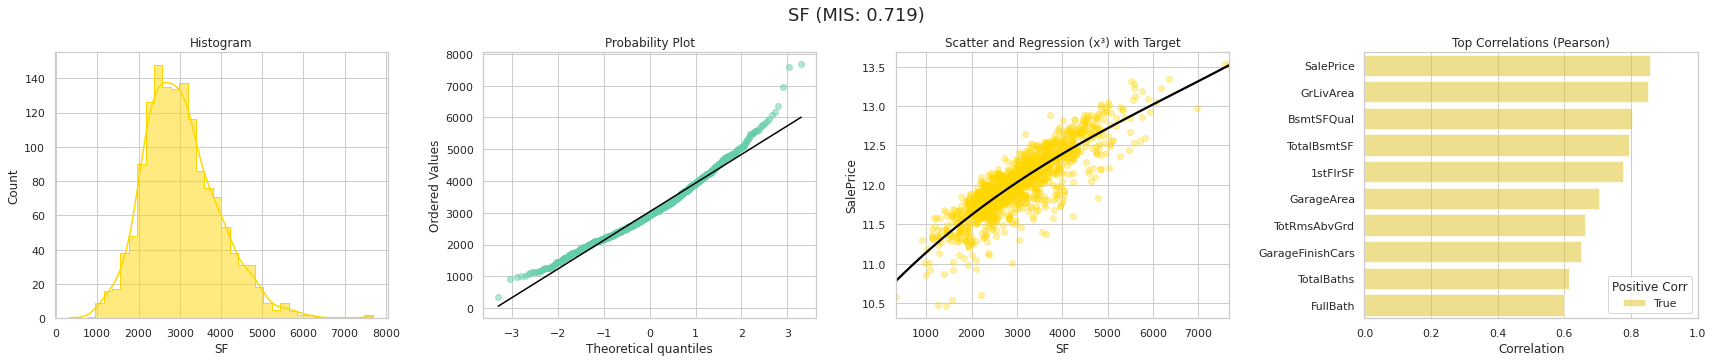

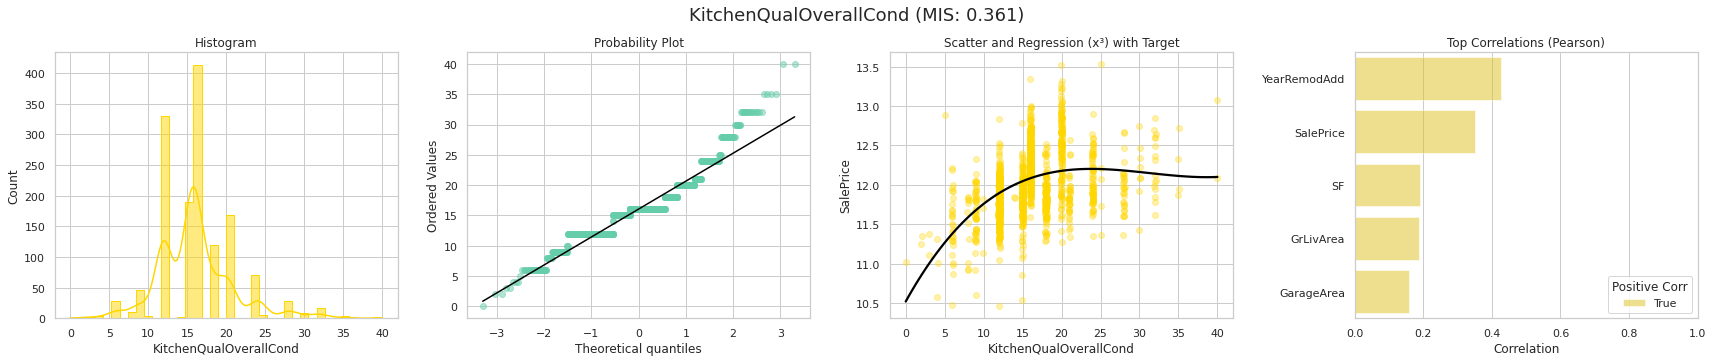

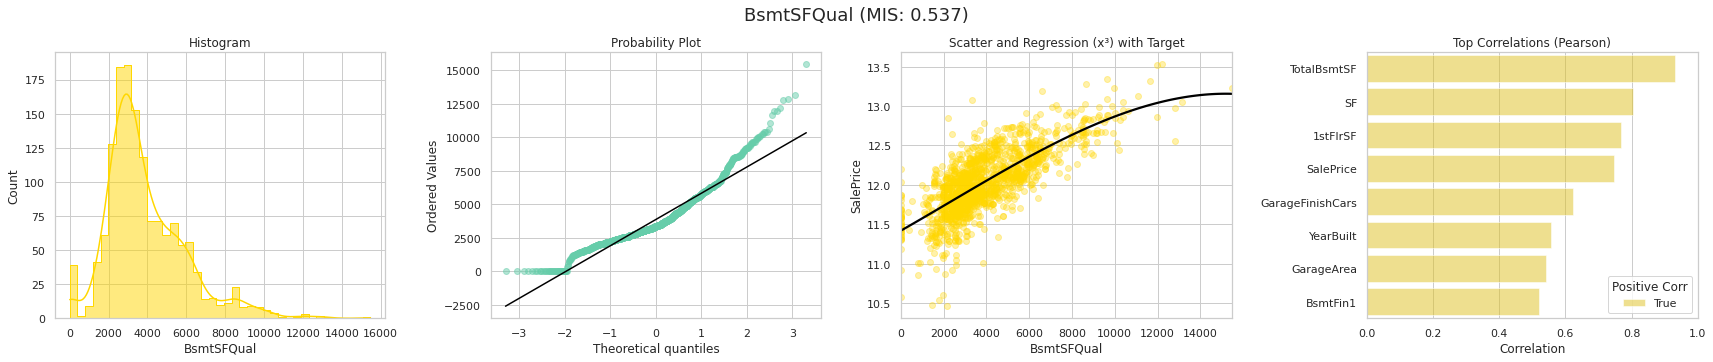

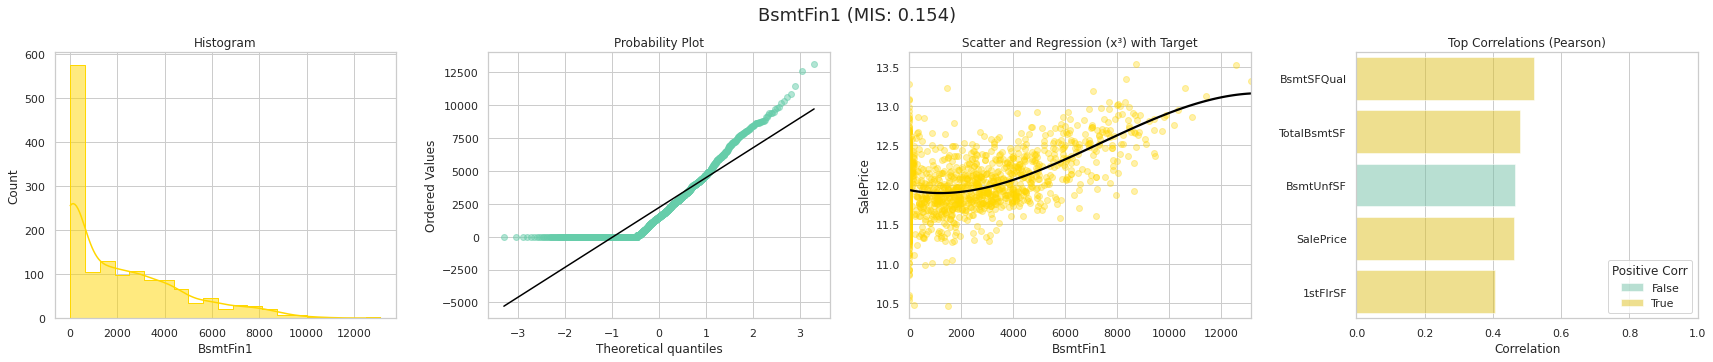

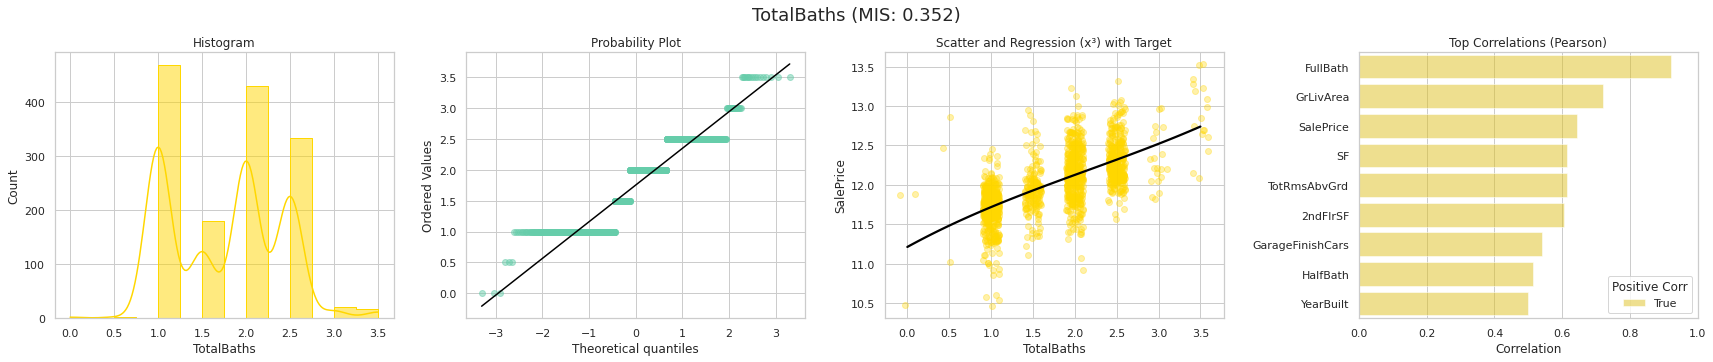

In [99]:
plot_set(train, target, new_features)

My goal for new features was to have a nice distribution across *SalePrice*.
<br>For a quick pass, a few decent features were found.
<br>*BsmtFin2* doesn't look promising from the graphs but seems to be somewhat informative. I'll keep it.

In [100]:
compare_score(train.drop('BsmtFin2', axis=1))

Lowest RMSE     0.11885
New RMSE        0.12063
Worse by        0.00178


## Feature Engineering to Pipeline

In [101]:
# Remember target transform!
# original_target -> np.log() -> .drop(outlier_ids, axis=0) -> target

In [102]:
class FeatureEngineering(TransformerMixin):
    """
    Pipeline to consolidate feature engineering transformations.
    """
    
    def __init__(self, drops=[]):
        self.drops = drops
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        new_X = X.copy()
        
        # New features
        new_X = new_X.assign(SF = lambda x: (new_X.TotalBsmtSF + new_X.GrLivArea + new_X.GarageArea))
        
        new_X = new_X.assign(BS1 = lambda x: (new_X.BsmtFinType1.cat.codes * new_X.BsmtFinSF1),
                             BS2 = lambda x: (new_X.BsmtFinType2.cat.codes * new_X.BsmtFinSF2))
        
        new_X = new_X.assign(BsmtSFQual = lambda x: (new_X.BsmtQual.cat.codes * new_X.TotalBsmtSF))
        
        new_X = new_X.assign(GarageFinishCars = lambda x: new_X.GarageFinish.cat.codes * new_X.GarageCars)
        
        new_X = new_X.assign(KitchenQualOverallCond=lambda x: new_X.KitchenQual.cat.codes * new_X.OverallCond.cat.codes)
        
        new_X = new_X.assign(TotalBaths=lambda x: new_X.FullBath + 0.5 * new_X.HalfBath)
        
        # Features to drop
        new_X = new_X.drop(self.drops, axis=1)
        new_X = new_X.drop(['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2'], axis=1)
        new_X = new_X.drop('GarageCars', axis=1)
        
        return new_X

In [103]:
feature_engineering_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering(selected_drops))
]) # selected_drops was union of features to drop after SULOV and considering class balances

In [104]:
full_pipeline = Pipeline([
    ('imputer', imputer_pipeline),
    ('encoder', encoder_pipeline),
    ('feature_engineering', feature_engineering_pipeline)
])

# Modelling
***
With quick analysis and transformations made to *train*, I feel ready to train a model.  
I did a hyperparameter search and moved that code to the appendix.

In [105]:
# I ran the search (in Appendix) for these params
selected_params = {'n_estimators': 751, 
                   'learning_rate': 0.12177128646131516, 
                   'max_depth': 2, 
                   'gamma': 0.000251073210724123, 
                   'min_child_weight': 1.2266087138381812, 
                   'reg_lambda': 1.7772392866942126, 
                   'reg_alpha': 0.115889838065404}
scores['tuned_XGBoost'] = score_dataset(train, target, XGBRegressor(**selected_params))

Finally, train a model with *selected_params*.

In [106]:
final_train = full_pipeline.fit_transform(original_train)
final_target = np.log(original_target)

final_train = final_train.drop(outlier_ids, axis=0)
final_target = final_target.drop(outlier_ids, axis=0)

for categorical in final_train.select_dtypes(["category"]):
        final_train[categorical] = final_train[categorical].cat.codes

In [107]:
tuned_XGBR = XGBRegressor(**selected_params)
trained_XGBR = tuned_XGBR.fit(final_train, final_target)

In [108]:
trained_XGBR.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.000251073210724123,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.12177128646131516,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1.2266087138381812,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 751,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0.115889838065404,
 'reg_lambda': 1.7772392866942126,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

I was **surprised** to find an optima in my searches that had a relatively low n_estimators and max_depth!
<br>Seems like quite a lightweight model.  
I'm hoping it generalizes well on *test*.

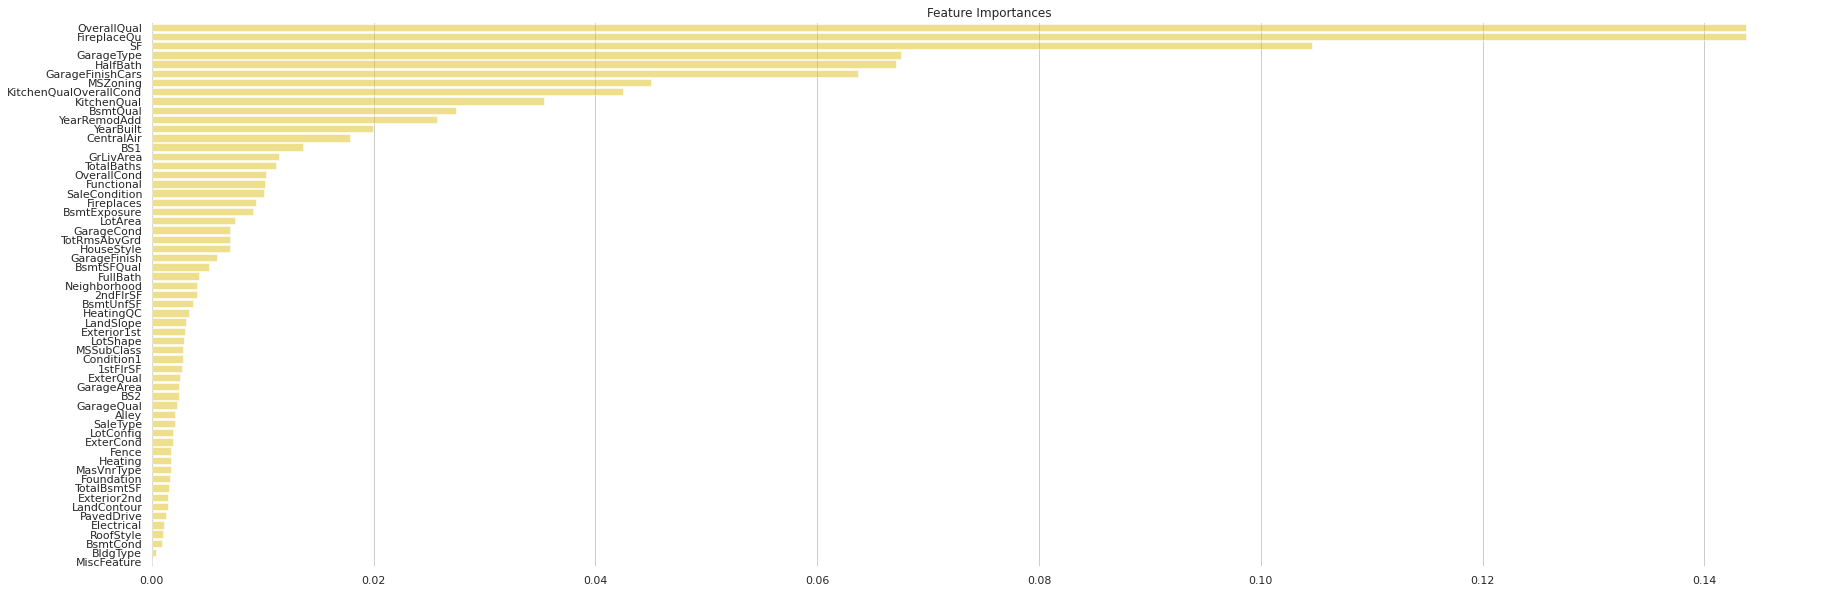

In [109]:
feature_importances = pd.Series(trained_XGBR.feature_importances_, index=final_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances.values, y=feature_importances.index, color='gold', alpha=0.5)
sns.despine(left=True, bottom=True)
plt.title(f"Feature Importances")  ; 

[Eyebrows raised when I saw *FireplaceQU*, will investigate if I return to this project.  
Also want to get more comfortable interpreting feature importances first.]

# Predict on Test
***

In [110]:
final_test = full_pipeline.fit_transform(original_test)
for categorical in final_test.select_dtypes(["category"]):
        final_test[categorical] = final_test[categorical].cat.codes

In [111]:
predictions = np.exp(trained_XGBR.predict(final_test))
predictions = pd.Series(predictions, index=final_test.index, name='SalePrice')

In [112]:
# Save to CSV
predictions.to_csv('submission.csv', index=True)

# Conclusion
***
As this project was largely experimental, I was often surprised on my findings.  
I admit I did not spend much time analysing my findings but this was intentional given my lack of domain knowledge in the housing market.  
<br>
If I return to this project I would invest more time in feature engineering as I suspect I would find the biggest gains there.  
I'd also try new models and ensemble them, as seems to be the approach at the top of the leaderboard.  
Before returning I would have to see how others approached feature engineering as I tried to go in blindly.

# APPENDIX
***

In [113]:
Stop Run All

SyntaxError: invalid syntax (<ipython-input-113-e985c836d68d>, line 1)

# Hyperparameter Tuning and Search

tune and search in [default value]:
1. eta (learning rate) [0.3]
2. gamma (decision boundary) [0]
3. max_depth (tree depth) [6]
4. min_child_weight [1]
5. lambda (L2 reg) [1]
6. alpha (L1 reg, high dimensionality) [0] 
7. n_estimators

In [ ]:
def objective(trial):
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000), # I tried ranges up to 5000
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'gamma': trial.suggest_uniform('gamma', 0, 1),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 0, 5),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 1, 5),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 2)
    }
    
    # Temporary--
    y = target.copy()
    X = train.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # --Temporary
    
    reg = XGBRegressor(**param)
    fitted = reg.fit(X, y)
    
    score = cross_val_score(
        fitted, X, y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200, timeout=3600)

In [ ]:
study.optimize(objective, n_trials=200, timeout=900)

In [ ]:
best_trial = study.best_trial
print(f"Out of {len(study.trials)} trials, the best trial had:")
print("  RMSE score of: {}".format(best_trial.value))
print("  with parameters: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
best_trial.params

{'n_estimators': 751,
 'learning_rate': 0.12177128646131516,
 'max_depth': 2,
 'gamma': 0.000251073210724123,
 'min_child_weight': 1.2266087138381812,
 'reg_lambda': 1.7772392866942126,
 'reg_alpha': 0.115889838065404}

trained_XGBR.get_params
- {'objective': 'reg:squarederror',
- 'base_score': 0.5,
- 'booster': 'gbtree',
- 'colsample_bylevel': 1,
- 'colsample_bynode': 1,
- 'colsample_bytree': 1,
- 'gamma': 0.000251073210724123,
- 'gpu_id': -1,
- 'importance_type': 'gain',
- 'interaction_constraints': '',
- 'learning_rate': 0.12177128646131516,
- 'max_delta_step': 0,
- 'max_depth': 2,
- 'min_child_weight': 1.2266087138381812,
- 'missing': nan,
- 'monotone_constraints': '()',
- 'n_estimators': 751,
- 'n_jobs': 4,
- 'num_parallel_tree': 1,
- 'random_state': 0,
- 'reg_alpha': 0.115889838065404,
- 'reg_lambda': 1.7772392866942126,
- 'scale_pos_weight': 1,
- 'subsample': 1,
- 'tree_method': 'exact',
- 'validate_parameters': 1,
- 'verbosity': None}